In [40]:
predictor.checkpointer

NameError: name 'predictor' is not defined

In [1]:
# import gc
# import torch
# gc.collect()
# with torch.no_grad():
#     torch.cuda.empty_cache()
# !nvidia-smi

In [2]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

# Some basic setup:
# Setup detectron2 logger
# import detectron2
from detectron2.utils.logger import setup_logger
# setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from sklearn.model_selection import train_test_split
cfg = get_cfg()


def DTLD_splitter(json_path):
    with open(json_path) as f:
        parsed = json.load(f)
    
    images = parsed['images']    
    if json_path.split('_')[1][:-5] == 'test':
        X_val = images
        X_train = []
    else:   
        percentage_test = 0.2    
        X_train, X_val= train_test_split(images, 
                                         test_size=percentage_test, 
                                         random_state=31)

    return X_train, X_val    

def get_DTLD(X_train):
    
    obj_count = 0
    dataset_dicts = []
#     for idx in range(len(X_train)):
    for idx, image in enumerate(X_train):
#         print(X_train)
        
        
        record = {}
#         images = X_train
        img_path = image['image_path']
        path_split = img_path.split('/')
        path_split[0] = '/multiverse/datasets/shared/DTLD'
        filename = '/'.join(path_split)
        height, width = 1024, 2048       
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
#         if filename != '/multiverse/datasets/shared/DTLD/Kassel/Kassel1/2015-05-15_14-31-18/DE_BBBR667_2015-05-15_14-31-34-031749_k0.tiff':
#             continue

        if path_split[-1] == 'DE_BBBR667_2015-04-23_13-20-52-402607_k0.tiff':
            continue
        objs = []        
        for anno in image['labels']:
            x = anno['x']
            y = anno['y']
            w = anno['w']
            h = anno['h']

            if x < 0:
                w = w + x
                x = 0                       
            elif y < 0:
                h = h + y
                y = 0
            elif x + w > 2048:
                w = 2048 - x
            elif y + h > 1024:
                h = 1024 - y     

            xmin = x
            ymin = y
            xmax = xmin + w 
            ymax = ymin + h
            
            aspect = anno['attributes']['aspects']
            direction = anno['attributes']['direction']
            orientation = anno['attributes']['orientation']
            occ = anno['attributes']['occlusion']
            reflection = anno['attributes']['reflection']          
            
            if reflection == 'reflected' or occ == 'occluded' or aspect == 'four_aspects' or orientation == 'horizontal' or aspect == 'unknown':
                continue            
            obj_count += 1 

#             dict_json = {'one_aspect': '1B', 
#                         'two_aspects': '2B',
#                         'three_aspects': '3B',
#                         'front': 'F',
#                         'back': 'B',
#                         'right': 'R',
#                         'left': 'L',}
            
#             dict_coco = {'1BF': '0', 
#                         '1BB': '1',
#                         '1BR': '2',
#                         '1BL': '3',
#                         '2BF': '4', 
#                         '2BB': '5',
#                         '2BR': '6',
#                         '2BL': '7',
#                         '3BF': '8', 
#                         '3BB': '9',
#                         '3BR': '10',
#                         '3BL': '11'}

            dict_7 = {'one_aspect': 0, 
                    'two_aspects': 1,
                    'three_aspects': 2,
                    'front': 3,
                    'back': 4,
                    'right': 5,
                    'left': 6}

#             state_asp = dict_json[aspect]
#             state_dir = dict_json[direction]
#             id = dict_coco[str(state_asp + state_dir)]
            id = [dict_7[aspect], dict_7[direction]]

            obj = {
                "bbox": [xmin, ymin, xmax, ymax],
                "bbox_mode": BoxMode.XYXY_ABS,                
                "category_id": id,
            }
            objs.append(obj)
        record["annotations"] = objs
#         print(obj_count)
        dataset_dicts.append(record)
    return dataset_dicts

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-zwiypbwq because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
from detectron2.data import DatasetCatalog

# json_path = '/multiverse/datasets/shared/DTLD/scripts/mini.json'
json_path = '/multiverse/datasets/shared/DTLD/v2.0/v2.0/DTLD_train.json'
test_path = '/multiverse/datasets/shared/DTLD/v2.0/v2.0/DTLD_test.json'
X_train, X_val = DTLD_splitter(json_path)
X_test, X_test2 = DTLD_splitter(test_path)
X_test = X_test + X_test2

if list(filter(lambda x: x=='train_set',DatasetCatalog.list())):
    DatasetCatalog.remove("train_set")
    DatasetCatalog.remove("val_set")  
    DatasetCatalog.remove("test_set")    
    
DatasetCatalog.register("train_set", lambda d=X_train[:2300]: get_DTLD(d))
DatasetCatalog.register("val_set", lambda d=X_val[:520]: get_DTLD(d))
DatasetCatalog.register("test_set", lambda d=X_test: get_DTLD(d))

MetadataCatalog.get("train_set").set(thing_classes=['1B', '2B', '3B', 'F', 'B', 'R', 'L'])
MetadataCatalog.get("val_set").set(thing_classes=['1B', '2B', '3B', 'F', 'B', 'R', 'L'])
MetadataCatalog.get("test_set").set(thing_classes=['1B', '2B', '3B', 'F', 'B', 'R', 'L'])



namespace(name='test_set',
          thing_classes=['1B', '2B', '3B', 'F', 'B', 'R', 'L'])

In [4]:
# DatasetCatalog.remove("reg_train")
DatasetCatalog.register("reg_train", lambda d=[X_train[10]]: get_DTLD(d))
MetadataCatalog.get("reg_train").set(thing_classes=['1B', '2B', '3B', 'F', 'B', 'R', 'L'])


namespace(name='reg_train',
          thing_classes=['1B', '2B', '3B', 'F', 'B', 'R', 'L'])

# Ratios of widths/heights

19722


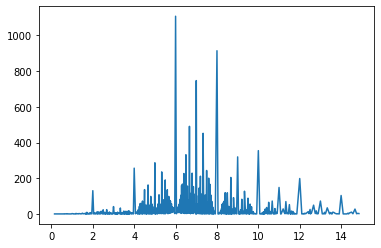

In [5]:
json_path = '/multiverse/datasets/shared/DTLD/v2.0/v2.0/DTLD_train.json'
X_train, X_val = DTLD_splitter(json_path)
ds = X_train + X_val

def get_wh(X_train):
    
    obj_count = 0
    w_list = []
    h_list = []
    wh = []
    ratio_arr = []
    
    for idx, image in enumerate(X_train[:(2300+520)]):   
        height, width = 1024, 2048      
             
        for anno in image['labels']:
            x = anno['x']
            y = anno['y']
            w = anno['w']
            h = anno['h']
            if x < 0:
                w = w + x
                x = 0                       
            elif y < 0:
                h = h + y
                y = 0
            elif x + w > 2048:
                w = 2048 - x
            elif y + h > 1024:
                h = 1024 - y  
                
            if w == 0 or h == 0:
                continue
                
            obj_count += 1
#             w_list.append(w*640/2048)
#             h_list.append(h*640/1024)
            
            wh.append([w*640/2048, h*640/1024])
            ratio_arr.append((h*640/1024)/(w*640/2048))
    
    print(obj_count)
    ratio_arr = np.array(ratio_arr)
    return wh, ratio_arr, 
            
wh, ratio_arr = get_wh(ds)     

import matplotlib.pyplot as plt

ratios, counts = np.unique(np.round(ratio_arr[ratio_arr < 15] ,decimals=2), axis = 0, return_counts=True)
# ratios = np.round(ratio_arr,decimals=2)
plt.plot(ratios, counts)
# res = np.asarray((ratios, counts)).T
# print(res[res[:,1]>2000])

# plt.hist(widths, bins=45, range=(0,45))
# from sklearn.cluster import KMeans
# kmeans_size = KMeans(n_clusters=9, random_state=0).fit(np.array((widths, heights)).T)
# x, y = kmeans_size.cluster_centers_.T
# plt.scatter(x,y)

In [6]:
# plt.hist(widths, bins=30, range=(0,15))

In [7]:
#  [[10 12]
#  [ 4 15]
#  [ 2  8]
#  [ 3 13]
#  [25 78]
#  [ 1  8]
#  [14 46]
#  [ 9 33]
#  [ 7 22]]

# Accuracy: 68.34%
# Boxes:
#  [[ 3 11]
#  [ 5 19]
#  [ 2  8]
#  [19 59]
#  [ 9 31]]
# Ratios:
#  [0.25, 0.26, 0.27, 0.29, 0.32]

# Accuracy: 70.16%
# Boxes:
#  [[ 0.9375  6.875 ]
#  [ 4.375  28.125 ]
#  [ 7.8125 48.125 ]
#  [ 2.8125 18.75  ]
#  [ 1.875  12.5   ]]
# Ratios:
#  [0.14, 0.15, 0.15, 0.16, 0.16]

In [8]:
# from detectron2.data.detection_utils import annotations_to_instances
import detectron2.data.detection_utils as utils

import copy
import logging
import numpy as np
from typing import List, Optional, Union
import torch
from detectron2.config import configurable

from detectron2.structures import (
    BitMasks,
    Boxes,
    BoxMode,
    Instances,
    Keypoints,
    PolygonMasks,
    RotatedBoxes,
    polygons_to_bitmask,
)

def anno_to_instances(annos, image_size, mask_format="polygon"):  
    """
    Create an :class:`Instances` object used by the models,
    from instance annotations in the dataset dict.
    Args:
        annos (list[dict]): a list of instance annotations in one image, each
            element for one instance.
        image_size (tuple): height, width
    Returns:
        Instances:
            It will contain fields "gt_boxes", "gt_classes",
            "gt_masks", "gt_keypoints", if they can be obtained from `annos`.
            This is the format that builtin models expect.
    """
    boxes = (
        np.stack(
            [BoxMode.convert(obj["bbox"], obj["bbox_mode"], BoxMode.XYXY_ABS) for obj in annos]
        )
        if len(annos)
        else np.zeros((0, 4))
    )
    target = Instances(image_size)
    target.gt_boxes = Boxes(boxes)

    classes = [(obj["category_id"]) for obj in annos]
    classes = torch.tensor(classes, dtype=torch.int64)
    target.gt_classes = classes

    if len(annos) and "segmentation" in annos[0]:
        segms = [obj["segmentation"] for obj in annos]
        if mask_format == "polygon":
            try:
                masks = PolygonMasks(segms)
            except ValueError as e:
                raise ValueError(
                    "Failed to use mask_format=='polygon' from the given annotations!"
                ) from e
        else:
            assert mask_format == "bitmask", mask_format
            masks = []
            for segm in segms:
                if isinstance(segm, list):
                    # polygon
                    masks.append(polygons_to_bitmask(segm, *image_size))
                elif isinstance(segm, dict):
                    # COCO RLE
                    masks.append(mask_util.decode(segm))
                elif isinstance(segm, np.ndarray):
                    assert segm.ndim == 2, "Expect segmentation of 2 dimensions, got {}.".format(
                        segm.ndim
                    )
                    # mask array
                    masks.append(segm)
                else:
                    raise ValueError(
                        "Cannot convert segmentation of type '{}' to BitMasks!"
                        "Supported types are: polygons as list[list[float] or ndarray],"
                        " COCO-style RLE as a dict, or a binary segmentation mask "
                        " in a 2D numpy array of shape HxW.".format(type(segm))
                    )
            # torch.from_numpy does not support array with negative stride.
            masks = BitMasks(
                torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
            )
        target.gt_masks = masks

    if len(annos) and "keypoints" in annos[0]:
        kpts = [obj.get("keypoints", []) for obj in annos]
        target.gt_keypoints = Keypoints(kpts)

    return target

utils.annotations_to_instances = anno_to_instances


In [9]:
def log2(pred_logits, gt_classes, prefix="fast_rcnn"):
    """
    Log the classification metrics to EventStorage.
    Args:
        pred_logits: Rx(K+1) logits. The last column is for background class.
        gt_classes: R labels
    """
    num_instances = gt_classes.numel()
    if num_instances == 0:
        return
#     pred_classes = pred_logits.argmax(dim=1)

    pred_classes = torch.topk(pred_logits, 2).indices
    bg_class_ind = pred_logits.shape[1] - 1

    fg_inds = (gt_classes >= 0) & (gt_classes < bg_class_ind)
    # print(fg_inds)
    fg_inds = torch.tensor([True if elem[0] == True and elem[1] == True else False for elem in fg_inds]) 
#     print(fg_inds)
    num_fg = fg_inds.count_nonzero().numel()
    fg_gt_classes = gt_classes[fg_inds]
#     print(fg_gt_classes)
    fg_pred_classes = pred_classes[fg_inds]
#     print(fg_pred_classes)
    cntr = 0
    # fg_pred_classes = torch.tensor([[6,6],[6,6],[6,5]])
    cntr += [1 for elem in (fg_pred_classes == bg_class_ind) if elem[0] == True and elem[1] == True].count(1)
    num_false_negative = int((fg_pred_classes == bg_class_ind).count_nonzero())
    num_false_negative -= cntr
    # print(num_false_negative)
    num_accurate = int((pred_classes.sort().values == gt_classes.sort().values).count_nonzero())
    # print(num_accurate)
    fg_num_accurate = int((fg_pred_classes.sort().values == fg_gt_classes.sort().values).count_nonzero())
    # print(fg_num_accurate)

    storage = get_event_storage()
    storage.put_scalar(f"{prefix}/cls_accuracy", num_accurate / num_instances)
    if num_fg > 0:
        storage.put_scalar(f"{prefix}/fg_cls_accuracy", fg_num_accurate / num_fg)
        storage.put_scalar(f"{prefix}/false_negative", num_false_negative / num_fg)

import detectron2.modeling.roi_heads.fast_rcnn as fast        
fast._log_classification_stats = log2

In [10]:
def box_reg_loss2(self, proposal_boxes, gt_boxes, pred_deltas, gt_classes):
    """
    Args:
        All boxes are tensors with the same shape Rx(4 or 5).
        gt_classes is a long tensor of shape R, the gt class label of each proposal.
        R shall be the number of proposals.
    """

    box_dim = proposal_boxes.shape[1]  # 4 or 5
    # Regression loss is only computed for foreground proposals (those matched to a GT)
    fg_inds = ((gt_classes >= 0) & (gt_classes < self.num_classes))[0]
#     print(fg_inds)
    fg_inds = (gt_classes >= 0) & (gt_classes < self.num_classes)
    fg_inds = torch.tensor([True if elem[0] == True and elem[1] == True else False for elem in fg_inds]) 
    
#     print(fg_inds)
    
#     pdb.set_trace()
    
    if pred_deltas.shape[1] == box_dim:  # cls-agnostic regression
        fg_pred_deltas = pred_deltas[fg_inds]
    else:
        fg_pred_deltas = pred_deltas.view(-1, self.num_classes, box_dim)[
            fg_inds, gt_classes[fg_inds,0] # 2 classes but they should have same bb thus take 1 gt.
        ]

    if self.box_reg_loss_type == "smooth_l1":
        gt_pred_deltas = self.box2box_transform.get_deltas(
            proposal_boxes[fg_inds],
            gt_boxes[fg_inds],
        )
        loss_box_reg = smooth_l1_loss(
            fg_pred_deltas, gt_pred_deltas, self.smooth_l1_beta, reduction="sum"
        )
    elif self.box_reg_loss_type == "giou":
        fg_pred_boxes = self.box2box_transform.apply_deltas(
            fg_pred_deltas, proposal_boxes[fg_inds]
        )
        loss_box_reg = giou_loss(fg_pred_boxes, gt_boxes[fg_inds], reduction="sum")
    else:
        raise ValueError(f"Invalid bbox reg loss type '{self.box_reg_loss_type}'")
    # The reg loss is normalized using the total number of regions (R), not the number
    # of foreground regions even though the box regression loss is only defined on
    # foreground regions. Why? Because doing so gives equal training influence to
    # each foreground example. To see how, consider two different minibatches:
    #  (1) Contains a single foreground region
    #  (2) Contains 100 foreground regions
    # If we normalize by the number of foreground regions, the single example in
    # minibatch (1) will be given 100 times as much influence as each foreground
    # example in minibatch (2). Normalizing by the total number of regions, R,
    # means that the single example in minibatch (1) and each of the 100 examples
    # in minibatch (2) are given equal influence.
    return loss_box_reg / max(gt_classes.shape[0], 1.0)  # return 0 if empty

fast.FastRCNNOutputLayers.box_reg_loss = box_reg_loss2

In [11]:
import pdb
import logging
from typing import Dict, List, Tuple, Union
import torch
from fvcore.nn import giou_loss, smooth_l1_loss
from torch import nn
from torch.nn import functional as F

from detectron2.config import configurable
from detectron2.layers import ShapeSpec, batched_nms, cat, cross_entropy, nonzero_tuple
from detectron2.modeling.box_regression import Box2BoxTransform
from detectron2.structures import Boxes, Instances
from detectron2.utils.events import get_event_storage


def losses2(self, predictions, proposals):
    """
    Args:
        predictions: return values of :meth:`forward()`.
        proposals (list[Instances]): proposals that match the features that were used
            to compute predictions. The fields ``proposal_boxes``, ``gt_boxes``,
            ``gt_classes`` are expected.
    Returns:
        Dict[str, Tensor]: dict of losses
    """
    scores, proposal_deltas = predictions
    losses2.iter += 1
#     if losses2.iter >= 119:        
#         pdb.set_trace()
        
    # parse classification outputs

#     print([p.gt_classes.shape for p in proposals])
#     aq = [[len(cls) == 1 for cls in p.gt_classes] for p in proposals]
#     print([[y for y in x if y == True] for x in aq])
    
    gt_classes = (
        cat([p.gt_classes for p in proposals], dim=0) if len(proposals) else torch.empty(0)
    )
    log2(scores, gt_classes)

    # parse box regression outputs
    if len(proposals):
        proposal_boxes = cat([p.proposal_boxes.tensor for p in proposals], dim=0)  # Nx4
        assert not proposal_boxes.requires_grad, "Proposals should not require gradients!"
        # If "gt_boxes" does not exist, the proposals must be all negative and
        # should not be included in regression loss computation.
        # Here we just use proposal_boxes as an arbitrary placeholder because its
        # value won't be used in self.box_reg_loss().
        gt_boxes = cat(
            [(p.gt_boxes if p.has("gt_boxes") else p.proposal_boxes).tensor for p in proposals],
            dim=0,
        )
    else:
        proposal_boxes = gt_boxes = torch.empty((0, 4), device=proposal_deltas.device)    
    
    
    gt_hot = torch.zeros(gt_classes.shape[0], scores.shape[1], device=proposal_deltas.device)
    for idx in range(gt_classes.shape[0]):
        gt_hot[idx][gt_classes[idx]] = 1
    
#     pdb.set_trace()
    
    losses = {
        "loss_cls": F.binary_cross_entropy_with_logits(scores, gt_hot, reduction="mean"),
        "loss_box_reg": self.box_reg_loss(
            proposal_boxes, gt_boxes, proposal_deltas, gt_classes
        ),
    }
    return {k: v * self.loss_weight.get(k, 1.0) for k, v in losses.items()}

import detectron2.modeling.roi_heads.fast_rcnn as fast

fast.FastRCNNOutputLayers.losses = losses2
losses2.iter = 0

# MAPPER to change augmentations and include annotations for valid set

In [12]:
from detectron2.data.dataset_mapper import *
import copy
import logging
import numpy as np
from typing import List, Optional, Union
import torch

from detectron2.config import configurable

from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T



def __call2__(self, dataset_dict):
    """
    Args:
        dataset_dict (dict): Metadata of one image, in Detectron2 Dataset format.
    Returns:
        dict: a format that builtin models in detectron2 accept
    """
#     print('ANANIN ya kardesim hadi artik kuruduk kaldiq')   
   
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    # USER: Write your own image loading if it's not from a file
    image = utils.read_image(dataset_dict["file_name"], format=self.image_format)
    utils.check_image_size(dataset_dict, image)   
    
#     pdb.set_trace() # NIYE CALISMIYON AMUHA KODUM

    # USER: Remove if you don't do semantic/panoptic segmentation.
    
    aug_input = T.AugInput(image, sem_seg=None)
    
    if self.is_train:
        augmentations = [T.Resize((640,640)), T.RandomFlip()] # trying this way to resize instead of shortedge
#         augmentations = [T.Resize((512,2048)), T.RandomFlip()] # trying this way to resize instead of shortedge
        
#         print("Real augmentations used for training:", augmentations)
    else:
        augmentations = [T.Resize((640,640))] # trying this way to resize instead of shortedge 
        augmentations = [T.Resize((1024,2048))] # trying this way to resize instead of shortedge 
        
#         print("Real augmentations used for testing/validating:", augmentations)        
        
    self.augmentations = T.AugmentationList(augmentations)
    
    transforms = self.augmentations(aug_input)
    image, sem_seg_gt = aug_input.image, aug_input.sem_seg
            
    image_shape = image.shape[:2]  # h, w
#     print(image_shape)

    # Pytorch's dataloader is efficient on torch.Tensor due to shared-memory,
    # but not efficient on large generic data structures due to the use of pickle & mp.Queue.
    # Therefore it's important to use torch.Tensor.
    dataset_dict["image"] = torch.as_tensor(np.ascontiguousarray(image.transpose(2, 0, 1)))
    if sem_seg_gt is not None:
        dataset_dict["sem_seg"] = torch.as_tensor(sem_seg_gt.astype("long"))

    # USER: Remove if you don't use pre-computed proposals.
    # Most users would not need this feature.
    if self.proposal_topk is not None:
        utils.transform_proposals(
            dataset_dict, image_shape, transforms, proposal_topk=self.proposal_topk
        )
    
    if not self.is_train:
        # USER: Modify this if you want to keep them for some reason.
    #         dataset_dict.pop("annotations", None)
        dataset_dict.pop("sem_seg_file_name", None)
        return dataset_dict

    if "annotations" in dataset_dict:
        self._transform_annotations(dataset_dict, transforms, image_shape)

    return dataset_dict

DatasetMapper.__call__ = __call2__

In [44]:
import detectron2.data.detection_utils as util
import numpy as np
import cv2
from detectron2.utils.file_io import PathManager

def read_image2(file_name, format=None):
    """
    
    Read an image into the given format.
    Will apply rotation and flipping if the image has such exif information.
    Args:
        file_name (str): image file path
        format (str): one of the supported image modes in PIL, or "BGR" or "YUV-BT.601".
    Returns:
        image (np.ndarray):
            an HWC image in the given format, which is 0-255, uint8 for
            supported image modes in PIL or "BGR"; float (0-1 for Y) for YUV-BT.601.
    """

    img = cv2.imread(file_name,-1)
    img = cv2.cvtColor(img, cv2.COLOR_BAYER_GB2RGB)
    #     Images are saved in 12 bit raw -> shift 4 bits
    img = np.right_shift(img, 4)
    img = img.astype(np.uint8)
#     pdb.set_trace()
#     print(img, 'readimage')    
    # work around this bug: https://github.com/python-pillow/Pillow/issues/3973
    img = util._apply_exif_orientation(img)
    return img

util.read_image = read_image2

# CUSTOM EVALUATOR from YOLOv4-5

In [50]:
# import logging
from detectron2.evaluation.evaluator import *
from collections import OrderedDict, defaultdict
from torchvision.ops import box_iou


class CustomEvaluator(DatasetEvaluator):
    
    
    def __init__(self, dataset_name):
        
        self._logger = logging.getLogger(__name__)
        self._cpu_device = torch.device("cpu")
        self._gpu = torch.device('cuda:0')
        self._metadata = MetadataCatalog.get(dataset_name)
        self.stats = []
        self.per_class = True
        self.dataset_name = dataset_name
        self.seen = 0
        self.input_list = np.array([])
        self.output_list = np.array([])
#         self.input_list = []
#         self.output_list = []
    
    def reset(self):
        self._predictions = [] # class name -> list of prediction strings
        
    
    def ap_per_class(self, tp, conf, pred_cls, target_cls):
        """ Compute the average precision, given the recall and precision curves.
        Source: https://github.com/rafaelpadilla/Object-Detection-Metrics.
        # Arguments
            tp:    True positives (nparray, nx1 or nx10).
            conf:  Objectness value from 0-1 (nparray).
            pred_cls: Predicted object classes (nparray).
            target_cls: True object classes (nparray).
        # Returns
            The average precision as computed in py-faster-rcnn.
        """
#       pdb.set_trace()
        # Sort by objectness
        i = np.argsort(-conf)
        tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

        # Find unique classes
        unique_classes = np.unique(target_cls)
        nc = unique_classes.shape[0] 
        px = np.linspace(0, 1, 1000)

        # Create Precision-Recall curve and compute AP for each class
        # pr_score = 0.1  # score to evaluate P and R https://github.com/ultralytics/yolov3/issues/898
        s = [unique_classes.shape[0], tp.shape[1]]  # number class, number iou thresholds (i.e. 10 for mAP0.5...0.95)
        # ap, p, r = np.zeros(s), np.zeros(s), np.zeros(s)
        ap, p, r = np.zeros((nc, tp.shape[1])), np.zeros((nc, 1000)), np.zeros((nc, 1000))

        for ci, c in enumerate(unique_classes):
            i = pred_cls == c
            n_gt = (target_cls == c).sum()  # Number of ground truth objects
            n_p = i.sum()  # Number of predicted objects

            if n_p == 0 or n_gt == 0:
                continue
            else:
                # Accumulate FPs and TPs
                fpc = (1 - tp[i]).cumsum(0)
                tpc = tp[i].cumsum(0)

                # Recall
                recall = tpc / (n_gt + 1e-16)  # recall curve
                r[ci] = np.interp(-px, -conf[i], recall[:, 0])  # r at pr_score, negative x, xp because xp decreases

                # Precision
                precision = tpc / (tpc + fpc)  # precision curve
                p[ci] = np.interp(-px, -conf[i], precision[:, 0])  # p at pr_score

                # AP from recall-precision curve
                for j in range(tp.shape[1]):
                    ap[ci, j] = self.compute_ap(recall[:, j], precision[:, j])

        # Compute F1 score (harmonic mean of precision and recall)
        f1 = 2 * p * r / (p + r + 1e-16)

        return p, r, ap, f1, unique_classes.astype('int32')
    

    def compute_ap(self, recall, precision):
        """ Compute the average precision, given the recall and precision curves.
        Code originally from https://github.com/rbgirshick/py-faster-rcnn.
        # Arguments
            recall:    The recall curve (list).
            precision: The precision curve (list).
        # Returns
            The average precision as computed in py-faster-rcnn.
        """
        # correct AP calculation
        # first append sentinel values at the end
        mrec = np.concatenate(([0.0], recall, [1.0]))
        mpre = np.concatenate(([0.0], precision, [0.0]))

        # mrec = np.concatenate(([0.], recall, [min(recall[-1] + 1E-3, 1.)]))
        # mpre = np.concatenate(([0.], precision, [0.]))

        # compute the precision envelope
        # for i in range(mpre.size - 1, 0, -1):
        #     mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        mpre = np.flip(np.maximum.accumulate(np.flip(mpre)))

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
#         i = np.where(mrec[1:] != mrec[:-1])[0]

# #         and sum (\Delta recall) * prec
#         ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
        x = np.linspace(0, 1, 101)  # 101-point interp (COCO)
        ap = np.trapz(np.interp(x, mrec, mpre), x)  # integrate

        return ap     
                

    def process(self, inputs, outputs):        
                
        iouv = torch.linspace(0.5, 0.95, 10).to(self._gpu)                
        for input, output in zip(inputs, outputs):
            image_id = input["image_id"]
            gt_boxes = torch.tensor([box['bbox'] for box in input['annotations']], device=self._gpu)
            tcls = torch.tensor([box['category_id'] for box in input['annotations']], device=self._gpu).reshape(-1)
#             gt_boxes = input['instances'].gt_boxes.tensor.to(self._gpu)
#             tcls = input['instances'].gt_classes.reshape(-1).to(self._gpu)
            instances = output["instances"]
            boxes = instances.pred_boxes.tensor
            self.scores = instances.scores
            classes = instances.pred_classes
            self.seen += 1
            nl = len(gt_boxes)*2  
            if len(instances) == 0:
                if nl:
                    self.stats.append((torch.zeros(0, 10, dtype=torch.bool), torch.Tensor(), torch.Tensor(), tcls.tolist()))
                continue

            correct = torch.zeros(len(instances), 10, dtype=torch.bool, device=self._gpu)
#             print(instances)
            if nl:
                detected = []  # target indices
                tcls_tensor = tcls

                # target boxes
                tbox = gt_boxes.repeat_interleave(2, dim=0)
                

                # Per target class
                for cls in torch.unique(tcls_tensor):
                    ti = (cls == tcls_tensor).nonzero(as_tuple=False).view(-1) # target indices 
                    pi = (cls == classes).nonzero(as_tuple=False).view(-1)  # prediction indices
                    

                    # Search for detections
                    if pi.shape[0]:
                        # Prediction to target ious
                        ious, i = box_iou(boxes[pi], tbox[ti]).max(1)  # best ious, indices

                        # Append detections
                        detected_set = set()
                        for j in (ious > iouv[0]).nonzero(as_tuple=False):
                            d = ti[i[j]]  # detected target
                            if d.item() not in detected_set:
                                detected_set.add(d.item())
                                detected.append(d)
                                correct[pi[j]] = ious[j] > iouv  # iou_thres is 1xn
#                                 pdb.set_trace()
                                
                                if len(detected) == nl:  # all targets already located in image
                                    break
        
            self.stats.append((correct.cpu(), self.scores.cpu(), classes.cpu(), tcls.tolist()))
            
#         self.input_list.append(inputs)
#         self.output_list.append(outputs)
#         self.input_list = np.append(self.input_list, inputs)
        self.output_list = np.append(self.output_list, np.array(outputs))
        
#         pdb.set_trace()
#         print(correct)
        

    def evaluate(self, img_ids=None):
        
        loss = torch.zeros(3, device=self._gpu)
        names = MetadataCatalog.get(self.dataset_name).thing_classes
        nc = cfg.MODEL.ROI_HEADS.NUM_CLASSES        
        stats = [np.concatenate(x, 0) for x in zip(*self.stats)]
        p, r, f1, mp, mr, map50, map = 0., 0., 0., 0., 0., 0., 0.
        ap, ap_class = [], []
#          pdb.set_trace()
        
        if len(stats) and stats[0].any():
            p, r, ap, f1, ap_class = self.ap_per_class(*stats)
            p, r, ap50, ap = p[:, 0], r[:, 0], ap[:, 0], ap.mean(1)  # [P, R, AP@0.5, AP@0.5:0.95]
            mp, mr, map50, map = p.mean(), r.mean(), ap50.mean(), ap.mean()
            nt = np.bincount(stats[3].astype(np.int64), minlength=nc)  # number of targets per class
        else:
            nt = torch.zeros(1)

        # Print results
        pf = '%20s' + '%12.3g' * 6  # print format
        print(pf % ('all', self.seen, nt.sum(), mp, mr, map50, map))
        
        # Print results per class
        if self.per_class and nc > 1 and len(stats):
            for i, c in enumerate(ap_class):
                print(pf % (names[c], self.seen, nt[c], p[i], r[i], ap50[i], ap[i]))

        maps = np.zeros(nc) + map
        for i, c in enumerate(ap_class):
            maps[c] = ap[i]
            
#         return (mp, mr, map50, map), maps
        
        ret = OrderedDict()
#         mAP = {iou: np.mean(x) for iou, x in aps.items()}
#         ret["bbox"] = {"AP": np.mean(list(mAP.values())), "AP50": mAP[50], "AP75": mAP[75]}
#         np.set_printoptions(precision=4)
        ret["bbox"] = {"AP": map, "AP50": map50, "Precision": mp, "Recall": mr}        
        return ret, self.output_list       
            
custom_eval = CustomEvaluator        



In [15]:
ycsaq = np.array([])
ycsaq = np.append(ycsaq, [15,3])
ycsaq = np.append(ycsaq, [12,3])
ycsaq

array([15.,  3., 12.,  3.])

# MODEL AND PARAMS

In [16]:
from detectron2.engine.train_loop import HookBase

class BestCheckpointer(HookBase):

    def before_train(self):
        self.best_metric = 0.0
        self.logger = logging.getLogger("detectron2.trainer")
        self.logger.info("######## Running best check pointer")

    def after_step(self):
        metric_name = 'bbox/AP50'
        if metric_name in self.trainer.storage._history:
            eval_metric, batches = self.trainer.storage.history(metric_name)._data[-1]
            if self.best_metric < eval_metric:
                self.best_metric = eval_metric
                self.logger.info(f"######## New best metric: {self.best_metric}")
                self.trainer.checkpointer.save(f"model_best_ap50")


In [17]:
# aq = torch.tensor([1,2])
# bq = torch.tensor([[4],[3]])
# torch.cat([aq,bq], 0)
# aq = [[len(cls) == 1 for cls in p.gt_classes] for p in proposals]
# [[y for y in x if y == True] for x in aq]
# am = [torch.Size([64, 2]), torch.Size([64, 2]), torch.Size([64, 2]), torch.Size([64, 2]), torch.Size([64, 2]), torch.Size([64, 2]), torch.Size([64, 2]), torch.Size([64, 2]), torch.Size([64, 2]), torch.Size([64, 2]), torch.Size([64, 2]), torch.Size([64, 2]), torch.Size([64]), torch.Size([64, 2]), torch.Size([64, 2]), torch.Size([64, 2])]
# aq = [p for p in am]
# b = [p[1] for p in am]
# b

In [18]:
# # Scheduler https://arxiv.org/pdf/1812.01187.pdf
# # https://pytorch.org/docs/stable/_modules/torch/optim/lr_scheduler.html#OneCycleLR
# from detectron2.solver.lr_scheduler import LRMultiplier, WarmupParamScheduler
# import torch.optim.lr_scheduler as lr_scheduler
# from detectron2.config import CfgNode
# import math

# def build_lr_scheduler2(
#     cfg: CfgNode, optimizer: torch.optim.Optimizer
# ) -> torch.optim.lr_scheduler._LRScheduler:
#     """
#     Build a LR scheduler from config.
#     """
#     name = cfg.SOLVER.LR_SCHEDULER_NAME

#     if name == "WarmupMultiStepLR":
#         steps = [x for x in cfg.SOLVER.STEPS if x <= cfg.SOLVER.MAX_ITER]
#         if len(steps) != len(cfg.SOLVER.STEPS):
#             logger = logging.getLogger(__name__)
#             logger.warning(
#                 "SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. "
#                 "These values will be ignored."
#             )
#         sched = MultiStepParamScheduler(
#             values=[cfg.SOLVER.GAMMA ** k for k in range(len(steps) + 1)],
#             milestones=steps,
#             num_updates=cfg.SOLVER.MAX_ITER,
#         )
#     elif name == "WarmupCosineLR":
#         sched = CosineParamScheduler(1, 0)
#     elif name == 'CosineLambda':
#         lf = lambda x: (((1 + math.cos(x * math.pi / cfg.TOT_EPOCH)) / 2) ** 1.0) * 0.8 + 0.2  # cosine        
#         sched = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
# #         return scheduler
    
#     else:
#         raise ValueError("Unknown LR scheduler: {}".format(name))      
    
#     sched = WarmupParamScheduler(
#         sched,
#         cfg.SOLVER.WARMUP_FACTOR,
#         min(cfg.SOLVER.WARMUP_ITERS / cfg.SOLVER.MAX_ITER, 1.0),
#         cfg.SOLVER.WARMUP_METHOD,
#     )
#     return LRMultiplier(optimizer, multiplier=sched, max_iter=cfg.SOLVER.MAX_ITER)


In [19]:
from detectron2.engine import DefaultTrainer
from detectron2.modeling import build_model

def build_evaluator(cfg, dataset_name, output_folder=None):
    
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    evaluator_list = [CustomEvaluator(dataset_name)]
    return DatasetEvaluators(evaluator_list)

class Trainer(DefaultTrainer):
    """
    We use the "DefaultTrainer" which contains pre-defined default logic for
    standard training workflow. They may not work for you, especially if you
    are working on a new research project. In that case you can write your
    own training loop. You can use "tools/plain_train_net.py" as an example.    """

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return build_evaluator(cfg, dataset_name, output_folder)
       
    def build_hooks(self):                  
        ret = super().build_hooks()     # THIS IS THE WAY FOR THE INHERITING AND THEN ADDING SOME DIFFERENCE
        ret.append(BestCheckpointer())
        return ret
    
    @classmethod
    def build_model(cls, cfg):
        """
        Returns:
            torch.nn.Module:
        It now calls :func:`detectron2.modeling.build_model`.
        Overwrite it if you'd like a different model.
        """
        model = build_model(cfg)
#         logger = logging.getLogger(__name__)
#         logger.info("Model:\n{}".format(model))
        return model
    
#     @classmethod
#     def build_lr_scheduler(cls, cfg, optimizer):
#         """
#         It now calls :func:`detectron2.solver.build_lr_scheduler`.
#         Overwrite it if you'd like a different scheduler.
#         """
#         return build_lr_scheduler2(cfg, optimizer)


In [20]:
# %debug
import logging
import numpy as np
from typing import List, Union
import pycocotools.mask as mask_util
import torch
from PIL import Image

from detectron2.structures import (
    BitMasks,
    Boxes,
    BoxMode,
    Instances,
    Keypoints,
    PolygonMasks,
    RotatedBoxes,
    polygons_to_bitmask,
)
from detectron2.utils.file_io import PathManager

from detectron2.data import transforms as T
from detectron2.data.catalog import MetadataCatalog

def transform_instance_annotations2(
    annotation, transforms, image_size, *, keypoint_hflip_indices=None
):
    """
    Apply transforms to box, segmentation and keypoints annotations of a single instance.
    It will use `transforms.apply_box` for the box, and
    `transforms.apply_coords` for segmentation polygons & keypoints.
    If you need anything more specially designed for each data structure,
    you'll need to implement your own version of this function or the transforms.
    Args:
        annotation (dict): dict of instance annotations for a single instance.
            It will be modified in-place.
        transforms (TransformList or list[Transform]):
        image_size (tuple): the height, width of the transformed image
        keypoint_hflip_indices (ndarray[int]): see `create_keypoint_hflip_indices`.
    Returns:
        dict:
            the same input dict with fields "bbox", "segmentation", "keypoints"
            transformed according to `transforms`.
            The "bbox_mode" field will be set to XYXY_ABS.
    """
    if isinstance(transforms, (tuple, list)):
        transforms = T.TransformList(transforms)
    # bbox is 1d (per-instance bounding box)
    bbox = BoxMode.convert(annotation["bbox"], annotation["bbox_mode"], BoxMode.XYXY_ABS)
    # clip transformed bbox to image size    
#     print('pre aug {}'.format(bbox))
    bbox = transforms.apply_box(np.array([bbox]))[0].clip(min=0)
#     print('after {}'.format(bbox))
    
    if bbox[0] == bbox[2]:
        bbox[2] += 1
    elif bbox[1] == bbox[3]:
        bbox[3] += 1
        
    annotation["bbox"] = np.minimum(bbox, list(image_size + image_size)[::-1])
    annotation["bbox_mode"] = BoxMode.XYXY_ABS

    if "segmentation" in annotation:
        # each instance contains 1 or more polygons
        segm = annotation["segmentation"]
        if isinstance(segm, list):
            # polygons
            polygons = [np.asarray(p).reshape(-1, 2) for p in segm]
            annotation["segmentation"] = [
                p.reshape(-1) for p in transforms.apply_polygons(polygons)
            ]
        elif isinstance(segm, dict):
            # RLE
            mask = mask_util.decode(segm)
            mask = transforms.apply_segmentation(mask)
            assert tuple(mask.shape[:2]) == image_size
            annotation["segmentation"] = mask
        else:
            raise ValueError(
                "Cannot transform segmentation of type '{}'!"
                "Supported types are: polygons as list[list[float] or ndarray],"
                " COCO-style RLE as a dict.".format(type(segm))
            )

    if "keypoints" in annotation:
        keypoints = transform_keypoint_annotations(
            annotation["keypoints"], transforms, image_size, keypoint_hflip_indices
        )
        annotation["keypoints"] = keypoints

    return annotation

utils.transform_instance_annotations = transform_instance_annotations2

In [21]:
###################################################################################

In [22]:
from typing import Dict, List, Optional, Tuple, Union
import torch
import torch.nn.functional as F
from torch import nn

from detectron2.config import configurable
from detectron2.layers import Conv2d, ShapeSpec, cat
from detectron2.structures import Boxes, ImageList, Instances, pairwise_iou
from detectron2.utils.events import get_event_storage
from detectron2.utils.memory import retry_if_cuda_oom
from detectron2.utils.registry import Registry

# from detectron2.modeling.anchor_generator import build_anchor_generator
from detectron2.modeling.box_regression import Box2BoxTransform, _dense_box_regression_loss
from detectron2.modeling.matcher import Matcher
from detectron2.modeling.sampling import subsample_labels
from detectron2.modeling.proposal_generator.build import PROPOSAL_GENERATOR_REGISTRY
from detectron2.modeling.proposal_generator.proposal_utils import find_top_rpn_proposals

def label_and_sample_anchors2(
    self, anchors: List[Boxes], gt_instances: List[Instances]
) -> Tuple[List[torch.Tensor], List[torch.Tensor]]:
    """
    Args:
        anchors (list[Boxes]): anchors for each feature map.
        gt_instances: the ground-truth instances for each image.
    Returns:
        list[Tensor]:
            List of #img tensors. i-th element is a vector of labels whose length is
            the total number of anchors across all feature maps R = sum(Hi * Wi * A).
            Label values are in {-1, 0, 1}, with meanings: -1 = ignore; 0 = negative
            class; 1 = positive class.
        list[Tensor]:
            i-th element is a Rx4 tensor. The values are the matched gt boxes for each
            anchor. Values are undefined for those anchors not labeled as 1.
    """
    anchors = Boxes.cat(anchors)
#     print(gt_instances)
#     pdb.set_trace()    
    gt_boxes = [x.gt_boxes for x in gt_instances]
    image_sizes = [x.image_size for x in gt_instances]
    del gt_instances
    
    gt_labels = []
    matched_gt_boxes = []
    for image_size_i, gt_boxes_i in zip(image_sizes, gt_boxes):
        """
        image_size_i: (h, w) for the i-th image
        gt_boxes_i: ground-truth boxes for i-th image
        """

        match_quality_matrix = retry_if_cuda_oom(pairwise_iou)(gt_boxes_i, anchors)
        matched_idxs, gt_labels_i = retry_if_cuda_oom(self.anchor_matcher)(match_quality_matrix)
        ycs = torch.nonzero(match_quality_matrix, as_tuple=True)
        aq = match_quality_matrix[ycs]
#         print(aq[aq>0.5])
#         print(aq.max())
        
#         pdb.set_trace()
        
        # Matching is memory-expensive and may result in CPU tensors. But the result is small
        gt_labels_i = gt_labels_i.to(device=gt_boxes_i.device)
        del match_quality_matrix

        if self.anchor_boundary_thresh >= 0:
            # Discard anchors that go out of the boundaries of the image
            # NOTE: This is legacy functionality that is turned off by default in Detectron2
            anchors_inside_image = anchors.inside_box(image_size_i, self.anchor_boundary_thresh)
            gt_labels_i[~anchors_inside_image] = -1

        # A vector of labels (-1, 0, 1) for each anchor
        gt_labels_i = self._subsample_labels(gt_labels_i)

        if len(gt_boxes_i) == 0:
            # These values won't be used anyway since the anchor is labeled as background
            matched_gt_boxes_i = torch.zeros_like(anchors.tensor)
        else:
            # TODO wasted indexing computation for ignored boxes
            matched_gt_boxes_i = gt_boxes_i[matched_idxs].tensor

        gt_labels.append(gt_labels_i)  # N,AHW
        matched_gt_boxes.append(matched_gt_boxes_i)
    return gt_labels, matched_gt_boxes

from detectron2.modeling.proposal_generator import RPN
RPN.label_and_sample_anchors = label_and_sample_anchors2


In [23]:
import numpy as np

def iou(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    :param box: tuple or array, shifted to the origin (i. e. width and height)
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: numpy array of shape (k, 0) where k is the number of clusters
    """
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_


def avg_iou(boxes, clusters):
    """
    Calculates the average Intersection over Union (IoU) between a numpy array of boxes and k clusters.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: average IoU as a single float
    """
    return np.mean([np.max(iou(boxes[i], clusters)) for i in range(boxes.shape[0])])


def translate_boxes(boxes):
    """
    Translates all the boxes to the origin.
    :param boxes: numpy array of shape (r, 4)
    :return: numpy array of shape (r, 2)
    """
    new_boxes = boxes.copy()
    for row in range(new_boxes.shape[0]):
        new_boxes[row][2] = np.abs(new_boxes[row][2] - new_boxes[row][0])
        new_boxes[row][3] = np.abs(new_boxes[row][3] - new_boxes[row][1])
    return np.delete(new_boxes, [0, 1], axis=1)


def kmeans(boxes, k, dist=np.median):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    # the Forgy method will fail if the whole array contains the same rows
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        for row in range(rows):
            distances[row] = 1 - iou(boxes[row], clusters)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break

        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters

data = np.array(wh)
kmeans_anchors = np.sort(kmeans(data, k=5), axis=0)
print("Accuracy: {:.2f}%".format(avg_iou(data, kmeans_anchors) * 100))
print("Boxes:\n {}".format(kmeans_anchors))

ratios = np.round(kmeans_anchors[:, 0] / kmeans_anchors[:, 1], decimals=2).tolist()
print("Ratios:\n {}".format(sorted(ratios)))


Accuracy: 70.10%
Boxes:
 [[ 0.9375  6.875 ]
 [ 1.875  13.125 ]
 [ 3.125  20.    ]
 [ 4.6875 30.    ]
 [ 8.4375 51.875 ]]
Ratios:
 [0.14, 0.14, 0.16, 0.16, 0.16]


In [24]:
sizes = [[round(np.prod(anchor))] for anchor in kmeans_anchors]
sizes
# [int[np.prod(anchor)] for anchor in kmeans_anchors]
# kmeans_anchors, np.sort(kmeans_anchors, axis=0)0

[[6.0], [25.0], [62.0], [141.0], [438.0]]

In [59]:
import numpy as np
areas = [[6.0], [25.0], [62.0], [141.0], [438.0]]
[[int(np.rint(np.sqrt(area)))] for area in areas]

[[2], [5], [8], [12], [21]]

In [63]:
np.sqrt(62/3.25)

4.367713712793351

# ANCHOR_GENERATOR FUNCTIONS FOR STRIDE

In [25]:
from detectron2.modeling.anchor_generator import _broadcast_params, _create_grid_offsets

def _grid_anchors2(self, grid_sizes: List[List[int]]):
    """
    Returns:
        list[Tensor]: #featuremap tensors, each is (#locations x #cell_anchors) x 4
    """
    scale = 5*640/2048
#     strides = np.round(np.divide(scale*4, self.strides), 2).tolist()
#     strides = np.repeat(4, len(self.strides)).tolist()
#     strides = np.divide(self.strides, 2).tolist()
#     strides = np.concatenate([4], self.strides[1:]).tolist()
    
    anchors = []
    # buffers() not supported by torchscript. use named_buffers() instead
    buffers: List[torch.Tensor] = [x[1] for x in self.cell_anchors.named_buffers()]
        
    for size, stride, base_anchors in zip(grid_sizes, self.strides, buffers):
#         print(base_anchors, size)
        shift_x, shift_y = _create_grid_offsets2(size, stride, self.offset, base_anchors.device)
        shifts = torch.stack((shift_x, shift_y, shift_x, shift_y), dim=1)

        anchors.append((shifts.view(-1, 1, 4) + base_anchors.view(1, -1, 4)).reshape(-1, 4))
#         pdb.set_trace()

    return anchors

from detectron2.modeling.anchor_generator import DefaultAnchorGenerator
# DefaultAnchorGenerator._grid_anchors = _grid_anchors2

def generate_cell_anchors2(self, sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.5, 1, 2)):
    """
    Generate a tensor storing canonical anchor boxes, which are all anchor
    boxes of different sizes and aspect_ratios centered at (0, 0).
    We can later build the set of anchors for a full feature map by
    shifting and tiling these tensors (see `meth:_grid_anchors`).
    Args:
        sizes (tuple[float]):
        aspect_ratios (tuple[float]]):
    Returns:
        Tensor of shape (len(sizes) * len(aspect_ratios), 4) storing anchor boxes
            in XYXY format.
    """

    # This is different from the anchor generator defined in the original Faster R-CNN
    # code or Detectron. They yield the same AP, however the old version defines cell
    # anchors in a less natural way with a shift relative to the feature grid and
    # quantization that results in slightly different sizes for different aspect ratios.
    # See also https://github.com/facebookresearch/Detectron/issues/227

#     anchors = []
#     for size, aspect_ratio in zip(sizes, aspect_ratios):
#         area = size ** 2.0
# #         for aspect_ratio in aspect_ratios:
#             # s * s = w * h
#             # a = h / w
#             # ... some algebra ...
#             # w = sqrt(s * s / a)
#             # h = a * w
#         w = np.sqrt(area / aspect_ratio)
#         h = aspect_ratio * w
#         x0, y0, x1, y1 = -w / 2.0, -h / 2.0, w / 2.0, h / 2.0
#         anchors.append([x0, y0, x1, y1])
        
    anchors = []
    for size in sizes:
        area = size ** 2.0
        for aspect_ratio in aspect_ratios:
            # s * s = w * h
            # a = h / w
            # ... some algebra ...
            # w = sqrt(s * s / a)
            # h = a * w
            w = np.sqrt(area / aspect_ratio)
            h = aspect_ratio * w
            x0, y0, x1, y1 = -w / 2.0, -h / 2.0, w / 2.0, h / 2.0
            anchors.append([x0, y0, x1, y1])
#         return torch.tensor(anchors)        # BU SU AN SADECE ILK ANCHOR SIZE I ALIYO AQ
                       
    return torch.tensor(anchors)

# DefaultAnchorGenerator.generate_cell_anchors = generate_cell_anchors2


def _create_grid_offsets2(size: List[int], stride: int, offset: float, device: torch.device):
    grid_height, grid_width = size
    shifts_x = torch.arange(
        offset * stride, 640, step=stride, dtype=torch.float32, device=device
    )
#     print(shifts_x.shape)
    shifts_y = torch.arange(
        offset * stride, 640, step=stride, dtype=torch.float32, device=device
    )

    shift_y, shift_x = torch.meshgrid(shifts_y, shifts_x)
    shift_x = shift_x.reshape(-1)
    shift_y = shift_y.reshape(-1)
    return shift_x, shift_y

# DefaultAnchorGenerator._create_grid_offsets = _create_grid_offsets2


In [26]:
import detectron2.modeling.proposal_generator as pg
# from detectron2.modeling.proposal_generator import StandardRPNHead
from detectron2.utils.registry import Registry
from detectron2.config import configurable

RPN_HEAD_REGISTRY2 = Registry("RPN_HEAD")

@RPN_HEAD_REGISTRY2.register()
class CustomRPNHead(pg.StandardRPNHead):
    
    @configurable
    def __init__(
        self, *, in_channels: int, num_anchors: int, box_dim: int = 4, conv_dims: List[int] = (-1,)
    ):
        super().__init__(in_channels=in_channels, num_anchors=num_anchors)
#         nn.Module.__init__(self)
        
        
#         num_anchors = 16
        cur_channels = in_channels        
        
#         self.objectness_logits = nn.Conv2d(cur_channels, num_anchors, kernel_size=1, stride=1)
#         self.anchor_deltas = nn.Conv2d(cur_channels, num_anchors * box_dim, kernel_size=1, stride=1)
#         for layer in self.modules():
#             if isinstance(layer, nn.Conv2d):
#                 nn.init.normal_(layer.weight, std=0.01)
#                 nn.init.constant_(layer.bias, 0)
                
#     def forward(self, features: List[torch.Tensor]):
#         """
#         Args:
#             features (list[Tensor]): list of feature maps
#         Returns:
#             list[Tensor]: A list of L elements.
#                 Element i is a tensor of shape (N, A, Hi, Wi) representing
#                 the predicted objectness logits for all anchors. A is the number of cell anchors.
#             list[Tensor]: A list of L elements. Element i is a tensor of shape
#                 (N, A*box_dim, Hi, Wi) representing the predicted "deltas" used to transform anchors
#                 to proposals.
#         """

#         pred_objectness_logits = []
#         pred_anchor_deltas = []
#         for x in features:
#             t = self.conv(x)                
#     #         width = x.shape[-1]
#     #         im_size = 640
# #             num_anchors = 1
# #             cur_channels = 256
# #             box_dim = 4
# #             self.objectness_logits2 = nn.Conv2d(cur_channels, num_anchors, kernel_size=1, stride=1, device='cuda:0')
# #             print(self.objectness_logits(t).shape)
# #             print('helpme bro', self.objectness_logits2(t).shape)
# #             pdb.set_trace()        

#             # 1x1 conv for predicting box2box transform deltas
#     #         self.anchor_deltas = nn.Conv2d(cur_channels, num_anchors * box_dim, kernel_size=1, stride=1).to('cuda:0')
#     #         print(self.objectness_logits)
#             pred_objectness_logits.append(self.objectness_logits(t))
#             pred_anchor_deltas.append(self.anchor_deltas(t))
#         return pred_objectness_logits, pred_anchor_deltas
    
    @classmethod
    def from_config(cls, cfg, input_shape):
        return super().from_config(cfg, input_shape)
        
    
#     @classmethod
#     def from_config(cls, cfg, input_shape):
#         # Standard RPN is shared across levels:
#         in_channels = [s.channels for s in input_shape]
#         assert len(set(in_channels)) == 1, "Each level must have the same channel!"
#         in_channels = in_channels[0]

#         # RPNHead should take the same input as anchor generator
#         # NOTE: it assumes that creating an anchor generator does not have unwanted side effect.
#         anchor_generator = build_anchor_generator(cfg, input_shape)
#         num_anchors = anchor_generator.num_anchors
#         box_dim = anchor_generator.box_dim
#         assert (
#             len(set(num_anchors)) == 1
#         ), "Each level must have the same number of anchors per spatial position"
#         return {
#             "in_channels": in_channels,
#             "num_anchors": num_anchors[0],
#             "box_dim": box_dim,
#             "conv_dims": cfg.MODEL.RPN.CONV_DIMS,
#         }



# pg.StandardRPNHead = CustomRPNHead
# StandardRPNHead.forward = forward9

In [27]:
import detectron2.modeling.proposal_generator.rpn as pgr

def build_rpn_head2(cfg, input_shape):
    """
    Build an RPN head defined by `cfg.MODEL.RPN.HEAD_NAME`.
    """
    name = "CustomRPNHead"
    return RPN_HEAD_REGISTRY2.get(name)(cfg, input_shape)
pgr.build_rpn_head = build_rpn_head2

In [28]:
def predict_probs2(
    self, predictions: Tuple[torch.Tensor, torch.Tensor], proposals: List[Instances]
):
    """
    Args:
        predictions: return values of :meth:`forward()`.
        proposals (list[Instances]): proposals that match the features that were
            used to compute predictions.
    Returns:
        list[Tensor]:
            A list of Tensors of predicted class probabilities for each image.
            Element i has shape (Ri, K + 1), where Ri is the number of proposals for image i.
    """
    scores, _ = predictions
    num_inst_per_image = [len(p) for p in proposals]
    probs = F.softmax(scores, dim=-1)
    probs_sig = F.sigmoid(scores) # changing prob to sigmoid for multilabel condition
#     print(probs[:5], probs_sig[:5])
    return probs_sig.split(num_inst_per_image, dim=0)

fast.FastRCNNOutputLayers.predict_probs = predict_probs2

In [29]:
cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train_set",)
cfg.DATASETS.TEST = ("val_set",)
cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
# cfg.MODEL.WEIGHTS = ""
cfg.SOLVER.IMS_PER_BATCH = 12 # 8 is good idk why
cfg.SOLVER.BASE_LR = 0.01  # pick a good LR
NUM_GPUS = 1
single_iteration = NUM_GPUS * cfg.SOLVER.IMS_PER_BATCH
train_len = len(DatasetCatalog.get('train_set'))
iterations_for_one_epoch = np.ceil(train_len / single_iteration)
tot_epoch = 70
cfg.SOLVER.MAX_ITER = int(iterations_for_one_epoch * tot_epoch)
cfg.SOLVER.WARMUP_ITERS = int(iterations_for_one_epoch)*5 # should put this otherwise it is 1k 3*5*8
# cfg.SOLVER.MAX_ITER = 2500   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.INPUT.MIN_SIZE_TRAIN = (1024,)
cfg.INPUT.MAX_SIZE_TRAIN = 2048
cfg.OUTPUT_DIR = '/multiverse/datasets/shared/DTLD/detectron2/imsize_640_mini_p4only_4stride/'
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0
cfg.TEST.EVAL_PERIOD = int(iterations_for_one_epoch)*3
cfg.SOLVER.LR_SCHEDULER_NAME = 'WarmupCosineLR'

# sizes = [[2*int(np.sqrt(np.prod(anchor)))] for anchor in np.sort(kmeans_anchors, axis=0)]
# cfg.MODEL.ANCHOR_GENERATOR.SIZES = sizes

# in_features = []
# for size in sizes:
#     if size[0] < 35:
#         in_features.append('p2')
#     elif size[0] > 35 and size[0] < 99:
#         in_features.append('p3')
#     elif size[0] > 99 and size[0] < 291:
#         in_features.append('p4')
#     else:
#         in_features.append('p5')
        
cfg.MODEL.RPN.IN_FEATURES = ['p3', 'p4', 'p4', 'p5']
# cfg.MODEL.RPN.IN_FEATURES = in_features

# cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.1, 0.25, 0.33, 0.5, 1.0, 2.0, 3.0]]
# aspect_ratios = np.round((1/np.array(ratios)), 2).tolist()
# aspect_ratios = np.round(np.unique(aspect_ratios), 2).tolist()
# cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [aspect_ratios]
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[1, 3, 3.5, 4, 5]]
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[64], [128], [256], [512]]
# cfg.MODEL.RPN.HEAD_NAME = "CustomRPNHead"


# BEST = 0.31 = [[2, 3, 3.5, 4, 5]], [[16], [32], [64], [128]], ['p2', 'p2', 'p3', 'p4']

cfg.MODEL.RPN.IN_FEATURES = ['p2', 'p3', 'p4', 'p5', 'p6']
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.5, 1.0, 2.0]]
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[32], [64], [128], [256], [512]]
print(cfg.MODEL.RPN.IN_FEATURES)

# Accuracy: 70.16%
# # Boxes:
#  [[ 0.9375  6.875 ]
#  [ 4.375  28.125 ]
#  [ 7.8125 48.125 ]
#  [ 2.8125 18.75  ]
#  [ 1.875  12.5   ]]
# Ratios:
#  [0.14, 0.15, 0.15, 0.16, 0.16]

# cfg.MODEL.RESNETS.RES2_OUT_CHANNELS = 256

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
setup_logger(output=cfg.OUTPUT_DIR)

trainer = Trainer(cfg) 
trainer.resume_or_load(resume=False)
iterations_for_one_epoch 

['p2', 'p3', 'p4', 'p5', 'p6']
[02/02 13:20:32 d2.data.build]: Removed 14 images with no usable annotations. 2286 images left.
[02/02 13:20:32 d2.data.build]: Distribution of instances among all 7 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|     1B     | 386          |     2B     | 2580         |     3B     | 9735         |
|     F      | 9703         |     B      | 282          |     R      | 1515         |
|     L      | 1201         |            |              |            |              |
|   total    | 25402        |            |              |            |              |
[02/02 13:20:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(1024,), max_size=2048, sample_style='choice'), RandomFlip()]
[02/02 13:20:32 d2.data.build]: Using training sampler TrainingSampler
[02/02 13:20:32

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (28, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (28,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

192.0

In [30]:
#     ASPECT_RATIOS: [[2, 3, 3.5, 4, 5]]
#     NAME: DefaultAnchorGenerator
#     OFFSET: 0.0
#     SIZES: [[16], [32], [64], [128]]

In [31]:
print( cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS, cfg.MODEL.ANCHOR_GENERATOR.SIZES)

[[0.5, 1.0, 2.0]] [[32], [64], [128], [256], [512]]


In [32]:
# "rpn/num_neg_anchors": 240.0, "rpn/num_pos_anchors": 16.0,
#  half stride, 5 ratios, double size generated anchors

In [33]:
# logger = logging.getLogger("detectron2.cfg")
# logger.info(cfg)
# trainer.train()

In [34]:
# def _log_class_stats(pred_logits, gt_classes, prefix="fast_rcnn"):
#     """
#     Log the classification metrics to EventStorage.
#     Args:
#         pred_logits: Rx(K+1) logits. The last column is for background class.
#         gt_classes: R labels
#     """
#     pdb.set_trace()
#     num_instances = gt_classes.numel()
#     if num_instances == 0:
#         return
#     pred_classes = pred_logits.argmax(dim=1)
#     bg_class_ind = pred_logits.shape[1] - 1

#     fg_inds = (gt_classes >= 0) & (gt_classes < bg_class_ind)
#     num_fg = fg_inds.nonzero().numel()
#     fg_gt_classes = gt_classes[fg_inds]
#     fg_pred_classes = pred_classes[fg_inds]

#     num_false_negative = (fg_pred_classes == bg_class_ind).nonzero().numel()
#     num_accurate = (pred_classes == gt_classes).nonzero().numel()
#     fg_num_accurate = (fg_pred_classes == fg_gt_classes).nonzero().numel()

#     storage = get_event_storage()
#     storage.put_scalar(f"{prefix}/cls_accuracy", num_accurate / num_instances)
#     if num_fg > 0:
#         storage.put_scalar(f"{prefix}/fg_cls_accuracy", fg_num_accurate / num_fg)
#         storage.put_scalar(f"{prefix}/false_negative", num_false_negative / num_fg)

# detectron2.modeling.roi_heads.fast_rcnn._log_classification_stats = _log_class_stats

In [35]:
# %tensorboard --logdir /exp --host localhost --port 8031

# PREDICTOR SETTINGS

# Predictor calls this function in Model and NMS here

In [36]:
# def fast_rcnn_inference_single_image2(
#     boxes,
#     scores,
#     image_shape: Tuple[int, int],
#     score_thresh: float,
#     nms_thresh: float,
#     topk_per_image: int,
# ):
#     """
#     Single-image inference. Return bounding-box detection results by thresholding
#     on scores and applying non-maximum suppression (NMS).
#     Args:
#         Same as `fast_rcnn_inference`, but with boxes, scores, and image shapes
#         per image.
#     Returns:
#         Same as `fast_rcnn_inference`, but for only one image.
#     """
#     valid_mask = torch.isfinite(boxes).all(dim=1) & torch.isfinite(scores).all(dim=1)
#     if not valid_mask.all():
#         boxes = boxes[valid_mask]
#         scores = scores[valid_mask]
        
# #     pdb.set_trace()

#     scores = scores[:, :-1] #excluding the background here 
#     num_bbox_reg_classes = boxes.shape[1] // 4
#     # Convert to Boxes to use the `clip` function ...
#     boxes = Boxes(boxes.reshape(-1, 4))
#     boxes.clip(image_shape)
#     boxes = boxes.tensor.view(-1, num_bbox_reg_classes, 4)  # R x C x 4

#     # 1. Filter results based on detection scores. It can make NMS more efficient
#     #    by filtering out low-confidence detections.
#     filter_mask = scores > score_thresh  # R x K
#     # R' x 2. First column contains indices of the R predictions;
#     # Second column contains indices of classes.
#     filter_inds = filter_mask.nonzero()
#     if num_bbox_reg_classes == 1:
#         boxes = boxes[filter_inds[:, 0], 0]
#     else:
#         boxes = boxes[filter_mask]
#     scores = scores[filter_mask]

#     # 2. Apply NMS for each class independently.
# #     nms_thresh = 0
#     keep = batched_nms(boxes, scores, filter_inds[:, 1], nms_thresh)
#     if topk_per_image >= 0:
#         keep = keep[:topk_per_image]
#     boxes, scores, filter_inds = boxes[keep], scores[keep], filter_inds[keep]

#     result = Instances(image_shape)
#     result.pred_boxes = Boxes(boxes)
#     result.scores = scores
#     result.pred_classes = filter_inds[:, 1]
    
# #     pdb.set_trace()
    
#     return result, filter_inds[:, 0]

# fast.fast_rcnn_inference_single_image = fast_rcnn_inference_single_image2

# Pred Aug for default predictor, not for inference_on_dataset

In [37]:
def __callpredaug__(self, original_image):
    """
    Args:
        original_image (np.ndarray): an image of shape (H, W, C) (in BGR order).
    Returns:
        predictions (dict):
            the output of the model for one image only.
            See :doc:`/tutorials/models` for details about the format.
    """
    with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
        # Apply pre-processing to image.
        if self.input_format == "RGB":
            # whether the model expects BGR inputs or RGB
            original_image = original_image[:, :, ::-1]
        height, width = original_image.shape[:2]
        self.aug = T.Resize((1024,2048)) # change the image to 640x640 for prediction
        image = self.aug.get_transform(original_image).apply_image(original_image)
        image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
        print(image.shape, height, width)
        
        inputs = {"image": image, "height": height, "width": width}
        predictions = self.model([inputs])[0]
        return predictions
from detectron2.engine.defaults import DefaultPredictor
DefaultPredictor.__call__ =  __callpredaug__

# Sigmoid for probabilites

In [38]:
def predict_probs2(
    self, predictions: Tuple[torch.Tensor, torch.Tensor], proposals: List[Instances]
):
    """
    Args:
        predictions: return values of :meth:`forward()`.
        proposals (list[Instances]): proposals that match the features that were
            used to compute predictions.
    Returns:
        list[Tensor]:
            A list of Tensors of predicted class probabilities for each image.
            Element i has shape (Ri, K + 1), where Ri is the number of proposals for image i.
    """
    scores, _ = predictions
    num_inst_per_image = [len(p) for p in proposals]
    probs = F.softmax(scores, dim=-1)
    probs_sig = F.sigmoid(scores) # changing prob to sigmoid for multilabel condition
#     print(probs[:5], probs_sig[:5])
    return probs_sig.split(num_inst_per_image, dim=0)

# fast.FastRCNNOutputLayers.predict_probs = predict_probs2

# Change of inference_on_dataset


In [39]:
from detectron2.evaluation.evaluator import *
import detectron2.evaluation.evaluator as evl

def inference_on_dataset2(
    model, data_loader, evaluator: Union[DatasetEvaluator, List[DatasetEvaluator], None]
):
    """
    Run model on the data_loader and evaluate the metrics with evaluator.
    Also benchmark the inference speed of `model.__call__` accurately.
    The model will be used in eval mode.
    Args:
        model (callable): a callable which takes an object from
            `data_loader` and returns some outputs.
            If it's an nn.Module, it will be temporarily set to `eval` mode.
            If you wish to evaluate a model in `training` mode instead, you can
            wrap the given model and override its behavior of `.eval()` and `.train()`.
        data_loader: an iterable object with a length.
            The elements it generates will be the inputs to the model.
        evaluator: the evaluator(s) to run. Use `None` if you only want to benchmark,
            but don't want to do any evaluation.
    Returns:
        The return value of `evaluator.evaluate()`
    """
    num_devices = get_world_size()
    logger = logging.getLogger(__name__)
    logger.info("Start inference on {} batches".format(len(data_loader)))

    total = len(data_loader)  # inference data loader must have a fixed length
    if evaluator is None:
        # create a no-op evaluator
        evaluator = DatasetEvaluators([])
    if isinstance(evaluator, abc.MutableSequence):
        evaluator = DatasetEvaluators(evaluator)
    evaluator.reset()

    num_warmup = min(5, total - 1)
    start_time = time.perf_counter()
    total_data_time = 0
    total_compute_time = 0
    total_eval_time = 0
    with ExitStack() as stack:
        if isinstance(model, nn.Module):
            stack.enter_context(inference_context(model))
        stack.enter_context(torch.no_grad())

        start_data_time = time.perf_counter()
        for idx, inputs in enumerate(data_loader):
            total_data_time += time.perf_counter() - start_data_time
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_data_time = 0
                total_compute_time = 0
                total_eval_time = 0

            start_compute_time = time.perf_counter()
#             pdb.set_trace()
            
            outputs = model(inputs)

#             img_show = np.array(np.transpose(inputs[0]['image'],(1,2,0)))
#             img_show = np.ascontiguousarray(img_show, dtype=np.uint8)
#             display_image_in_actual_size(img_show, outputs[0], inputs[0]['file_name'])        
#             wait = input("Press Enter to continue.")   
#             display_image_in_actual_size(read_image2(), out):
            
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time

            start_eval_time = time.perf_counter()
            
            evaluator.process(inputs, outputs)
            
            total_eval_time += time.perf_counter() - start_eval_time

            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            data_seconds_per_iter = total_data_time / iters_after_start
            compute_seconds_per_iter = total_compute_time / iters_after_start
            eval_seconds_per_iter = total_eval_time / iters_after_start
            total_seconds_per_iter = (time.perf_counter() - start_time) / iters_after_start
            if idx >= num_warmup * 2 or compute_seconds_per_iter > 5:
                eta = datetime.timedelta(seconds=int(total_seconds_per_iter * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    (
                        f"Inference done {idx + 1}/{total}. "
                        f"Dataloading: {data_seconds_per_iter:.4f} s/iter. "
                        f"Inference: {compute_seconds_per_iter:.4f} s/iter. "
                        f"Eval: {eval_seconds_per_iter:.4f} s/iter. "
                        f"Total: {total_seconds_per_iter:.4f} s/iter. "
                        f"ETA={eta}"
                    ),
                    n=5,
                )
            start_data_time = time.perf_counter()

    # Measure the time only for this worker (before the synchronization barrier)
    total_time = time.perf_counter() - start_time
    total_time_str = str(datetime.timedelta(seconds=total_time))
    # NOTE this format is parsed by grep
    logger.info(
        "Total inference time: {} ({:.6f} s / iter per device, on {} devices)".format(
            total_time_str, total_time / (total - num_warmup), num_devices
        )
    )
    total_compute_time_str = str(datetime.timedelta(seconds=int(total_compute_time)))
    logger.info(
        "Total inference pure compute time: {} ({:.6f} s / iter per device, on {} devices)".format(
            total_compute_time_str, total_compute_time / (total - num_warmup), num_devices
        )
    )

    results = evaluator.evaluate()
    # An evaluator may return None when not in main process.
    # Replace it by an empty dict instead to make it easier for downstream code to handle
    if results is None:
        results = {}
    return results

# evl.inference_on_dataset = inference_on_dataset2

# Using predictor directly

In [62]:
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "../testing/model_final.pth")
cfg.OUTPUT_DIR = '/multiverse/datasets/shared/DTLD/detectron2/imsize_640_mini_p4only_4stride/' # model_0009999.pth'
cfg.OUTPUT_DIR = '/multiverse/datasets/shared/DTLD/detectron2/full_size_mini/' # model_0009999.pth'
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_best_ap50.pth")
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TEST = ("val_set", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # set the testing threshold for this model
cfg.INPUT.MIN_SIZE_TEST = 640
cfg.INPUT.MAX_SIZE_TEST = 640
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0

cfg2save = cfg.dump()
with open(cfg.OUTPUT_DIR + 'config.yaml', 'w') as f:
    f.write(cfg2save)
predictor = DefaultPredictor(cfg)


In [41]:
# im_path = '/multiverse/datasets/shared/DTLD/Berlin/Berlin1/2015-04-17_10-50-41/DE_BBBR667_2015-04-17_10-50-47-637099_k0.tiff'
# im_path = '/multiverse/datasets/shared/DTLD/Berlin/Berlin1/2015-04-17_10-50-41/DE_BBBR667_2015-04-17_10-50-44-969603_k0.tiff'
# im_path = '/multiverse/datasets/shared/DTLD/Koeln/Koeln2/2015-04-23_12-59-43/DE_BBBR667_2015-04-23_12-59-44-012719_k0.tiff'
# im_path = '/multiverse/datasets/shared/DTLD/Kassel/Kassel5/2015-05-15_16-16-01/DE_BBBR667_2015-05-15_16-16-01-845103_k0.tiff'
# im_path = '/multiverse/datasets/shared/DTLD/Kassel/Kassel1/2015-05-15_14-31-18/DE_BBBR667_2015-05-15_14-31-34-031749_k0.tiff'
im_path = '/multiverse/datasets/shared/DTLD/Essen/Essen1/2015-04-22_11-16-04/DE_BBBR667_2015-04-22_11-16-17-026765_k0.tiff'
im = read_image2(im_path)
# out = predictor(im)

In [42]:
# print(out['instances'][0].pred_boxes.tensor.tolist()[0])
# print(out['instances'])


# Using inference_on_dataset

In [39]:
# !pip install Pympler

In [63]:
out_101 = None


In [64]:
from detectron2.data import build_detection_test_loader
from detectron2.evaluation.evaluator import inference_on_dataset
val_loader = build_detection_test_loader(cfg, "test_set")
evaluator = custom_eval("test_set")
out_101 = inference_on_dataset(predictor.model, val_loader, evaluator)

[02/02 19:58:58 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(640, 640), max_size=640, sample_style='choice')]
[02/02 19:58:58 d2.data.common]: Serializing 12452 elements to byte tensors and concatenating them all ...
[02/02 19:58:58 d2.data.common]: Serialized dataset takes 5.66 MiB
[02/02 19:58:58 d2.evaluation.evaluator]: Start inference on 12452 batches
[02/02 19:59:01 d2.evaluation.evaluator]: Inference done 11/12452. Dataloading: 0.0017 s/iter. Inference: 0.1379 s/iter. Eval: 0.0048 s/iter. Total: 0.1445 s/iter. ETA=0:29:57
[02/02 19:59:06 d2.evaluation.evaluator]: Inference done 46/12452. Dataloading: 0.0019 s/iter. Inference: 0.1377 s/iter. Eval: 0.0036 s/iter. Total: 0.1432 s/iter. ETA=0:29:36
[02/02 19:59:11 d2.evaluation.evaluator]: Inference done 81/12452. Dataloading: 0.0019 s/iter. Inference: 0.1379 s/iter. Eval: 0.0034 s/iter. Total: 0.1433 s/iter. ETA=0:29:32
[02/02 19:59:16 d2.evaluation.evaluator]: Inf

[02/02 20:02:34 d2.evaluation.evaluator]: Inference done 1471/12452. Dataloading: 0.0018 s/iter. Inference: 0.1404 s/iter. Eval: 0.0036 s/iter. Total: 0.1459 s/iter. ETA=0:26:42
[02/02 20:02:39 d2.evaluation.evaluator]: Inference done 1506/12452. Dataloading: 0.0018 s/iter. Inference: 0.1404 s/iter. Eval: 0.0036 s/iter. Total: 0.1459 s/iter. ETA=0:26:37
[02/02 20:02:44 d2.evaluation.evaluator]: Inference done 1541/12452. Dataloading: 0.0018 s/iter. Inference: 0.1404 s/iter. Eval: 0.0035 s/iter. Total: 0.1459 s/iter. ETA=0:26:31
[02/02 20:02:49 d2.evaluation.evaluator]: Inference done 1576/12452. Dataloading: 0.0018 s/iter. Inference: 0.1404 s/iter. Eval: 0.0035 s/iter. Total: 0.1459 s/iter. ETA=0:26:26
[02/02 20:02:54 d2.evaluation.evaluator]: Inference done 1611/12452. Dataloading: 0.0018 s/iter. Inference: 0.1404 s/iter. Eval: 0.0035 s/iter. Total: 0.1458 s/iter. ETA=0:26:20
[02/02 20:02:59 d2.evaluation.evaluator]: Inference done 1646/12452. Dataloading: 0.0018 s/iter. Inference: 0.

[02/02 20:06:17 d2.evaluation.evaluator]: Inference done 3002/12452. Dataloading: 0.0018 s/iter. Inference: 0.1407 s/iter. Eval: 0.0032 s/iter. Total: 0.1458 s/iter. ETA=0:22:57
[02/02 20:06:22 d2.evaluation.evaluator]: Inference done 3037/12452. Dataloading: 0.0018 s/iter. Inference: 0.1407 s/iter. Eval: 0.0031 s/iter. Total: 0.1458 s/iter. ETA=0:22:52
[02/02 20:06:27 d2.evaluation.evaluator]: Inference done 3072/12452. Dataloading: 0.0018 s/iter. Inference: 0.1407 s/iter. Eval: 0.0031 s/iter. Total: 0.1457 s/iter. ETA=0:22:47
[02/02 20:06:32 d2.evaluation.evaluator]: Inference done 3107/12452. Dataloading: 0.0018 s/iter. Inference: 0.1407 s/iter. Eval: 0.0031 s/iter. Total: 0.1457 s/iter. ETA=0:22:41
[02/02 20:06:37 d2.evaluation.evaluator]: Inference done 3142/12452. Dataloading: 0.0018 s/iter. Inference: 0.1407 s/iter. Eval: 0.0031 s/iter. Total: 0.1457 s/iter. ETA=0:22:36
[02/02 20:06:42 d2.evaluation.evaluator]: Inference done 3176/12452. Dataloading: 0.0018 s/iter. Inference: 0.

[02/02 20:10:00 d2.evaluation.evaluator]: Inference done 4538/12452. Dataloading: 0.0018 s/iter. Inference: 0.1407 s/iter. Eval: 0.0031 s/iter. Total: 0.1456 s/iter. ETA=0:19:12
[02/02 20:10:05 d2.evaluation.evaluator]: Inference done 4573/12452. Dataloading: 0.0018 s/iter. Inference: 0.1407 s/iter. Eval: 0.0031 s/iter. Total: 0.1456 s/iter. ETA=0:19:07
[02/02 20:10:10 d2.evaluation.evaluator]: Inference done 4608/12452. Dataloading: 0.0018 s/iter. Inference: 0.1407 s/iter. Eval: 0.0031 s/iter. Total: 0.1456 s/iter. ETA=0:19:02
[02/02 20:10:15 d2.evaluation.evaluator]: Inference done 4643/12452. Dataloading: 0.0018 s/iter. Inference: 0.1406 s/iter. Eval: 0.0031 s/iter. Total: 0.1456 s/iter. ETA=0:18:57
[02/02 20:10:20 d2.evaluation.evaluator]: Inference done 4678/12452. Dataloading: 0.0018 s/iter. Inference: 0.1407 s/iter. Eval: 0.0031 s/iter. Total: 0.1456 s/iter. ETA=0:18:51
[02/02 20:10:26 d2.evaluation.evaluator]: Inference done 4713/12452. Dataloading: 0.0018 s/iter. Inference: 0.

[02/02 20:13:43 d2.evaluation.evaluator]: Inference done 6062/12452. Dataloading: 0.0018 s/iter. Inference: 0.1408 s/iter. Eval: 0.0031 s/iter. Total: 0.1458 s/iter. ETA=0:15:31
[02/02 20:13:48 d2.evaluation.evaluator]: Inference done 6096/12452. Dataloading: 0.0018 s/iter. Inference: 0.1408 s/iter. Eval: 0.0031 s/iter. Total: 0.1458 s/iter. ETA=0:15:26
[02/02 20:13:53 d2.evaluation.evaluator]: Inference done 6131/12452. Dataloading: 0.0018 s/iter. Inference: 0.1408 s/iter. Eval: 0.0031 s/iter. Total: 0.1458 s/iter. ETA=0:15:21
[02/02 20:13:58 d2.evaluation.evaluator]: Inference done 6166/12452. Dataloading: 0.0018 s/iter. Inference: 0.1408 s/iter. Eval: 0.0031 s/iter. Total: 0.1458 s/iter. ETA=0:15:16
[02/02 20:14:03 d2.evaluation.evaluator]: Inference done 6201/12452. Dataloading: 0.0018 s/iter. Inference: 0.1408 s/iter. Eval: 0.0031 s/iter. Total: 0.1458 s/iter. ETA=0:15:11
[02/02 20:14:08 d2.evaluation.evaluator]: Inference done 6235/12452. Dataloading: 0.0018 s/iter. Inference: 0.

[02/02 20:17:26 d2.evaluation.evaluator]: Inference done 7589/12452. Dataloading: 0.0018 s/iter. Inference: 0.1409 s/iter. Eval: 0.0031 s/iter. Total: 0.1459 s/iter. ETA=0:11:49
[02/02 20:17:31 d2.evaluation.evaluator]: Inference done 7623/12452. Dataloading: 0.0018 s/iter. Inference: 0.1409 s/iter. Eval: 0.0031 s/iter. Total: 0.1459 s/iter. ETA=0:11:44
[02/02 20:17:37 d2.evaluation.evaluator]: Inference done 7658/12452. Dataloading: 0.0018 s/iter. Inference: 0.1409 s/iter. Eval: 0.0031 s/iter. Total: 0.1459 s/iter. ETA=0:11:39
[02/02 20:17:42 d2.evaluation.evaluator]: Inference done 7693/12452. Dataloading: 0.0018 s/iter. Inference: 0.1409 s/iter. Eval: 0.0031 s/iter. Total: 0.1459 s/iter. ETA=0:11:34
[02/02 20:17:47 d2.evaluation.evaluator]: Inference done 7728/12452. Dataloading: 0.0018 s/iter. Inference: 0.1409 s/iter. Eval: 0.0031 s/iter. Total: 0.1459 s/iter. ETA=0:11:29
[02/02 20:17:52 d2.evaluation.evaluator]: Inference done 7763/12452. Dataloading: 0.0018 s/iter. Inference: 0.

[02/02 20:21:10 d2.evaluation.evaluator]: Inference done 9122/12452. Dataloading: 0.0018 s/iter. Inference: 0.1410 s/iter. Eval: 0.0030 s/iter. Total: 0.1459 s/iter. ETA=0:08:05
[02/02 20:21:15 d2.evaluation.evaluator]: Inference done 9157/12452. Dataloading: 0.0018 s/iter. Inference: 0.1410 s/iter. Eval: 0.0030 s/iter. Total: 0.1459 s/iter. ETA=0:08:00
[02/02 20:21:20 d2.evaluation.evaluator]: Inference done 9192/12452. Dataloading: 0.0018 s/iter. Inference: 0.1410 s/iter. Eval: 0.0030 s/iter. Total: 0.1459 s/iter. ETA=0:07:55
[02/02 20:21:25 d2.evaluation.evaluator]: Inference done 9227/12452. Dataloading: 0.0018 s/iter. Inference: 0.1409 s/iter. Eval: 0.0030 s/iter. Total: 0.1459 s/iter. ETA=0:07:50
[02/02 20:21:31 d2.evaluation.evaluator]: Inference done 9262/12452. Dataloading: 0.0018 s/iter. Inference: 0.1409 s/iter. Eval: 0.0030 s/iter. Total: 0.1459 s/iter. ETA=0:07:45
[02/02 20:21:36 d2.evaluation.evaluator]: Inference done 9297/12452. Dataloading: 0.0018 s/iter. Inference: 0.

[02/02 20:24:54 d2.evaluation.evaluator]: Inference done 10654/12452. Dataloading: 0.0018 s/iter. Inference: 0.1410 s/iter. Eval: 0.0030 s/iter. Total: 0.1459 s/iter. ETA=0:04:22
[02/02 20:24:59 d2.evaluation.evaluator]: Inference done 10689/12452. Dataloading: 0.0018 s/iter. Inference: 0.1409 s/iter. Eval: 0.0030 s/iter. Total: 0.1459 s/iter. ETA=0:04:17
[02/02 20:25:04 d2.evaluation.evaluator]: Inference done 10724/12452. Dataloading: 0.0018 s/iter. Inference: 0.1409 s/iter. Eval: 0.0030 s/iter. Total: 0.1459 s/iter. ETA=0:04:12
[02/02 20:25:09 d2.evaluation.evaluator]: Inference done 10759/12452. Dataloading: 0.0018 s/iter. Inference: 0.1409 s/iter. Eval: 0.0030 s/iter. Total: 0.1459 s/iter. ETA=0:04:06
[02/02 20:25:14 d2.evaluation.evaluator]: Inference done 10793/12452. Dataloading: 0.0018 s/iter. Inference: 0.1410 s/iter. Eval: 0.0030 s/iter. Total: 0.1459 s/iter. ETA=0:04:02
[02/02 20:25:19 d2.evaluation.evaluator]: Inference done 10827/12452. Dataloading: 0.0018 s/iter. Inferen

[02/02 20:28:37 d2.evaluation.evaluator]: Inference done 12185/12452. Dataloading: 0.0018 s/iter. Inference: 0.1410 s/iter. Eval: 0.0030 s/iter. Total: 0.1459 s/iter. ETA=0:00:38
[02/02 20:28:42 d2.evaluation.evaluator]: Inference done 12220/12452. Dataloading: 0.0018 s/iter. Inference: 0.1410 s/iter. Eval: 0.0030 s/iter. Total: 0.1459 s/iter. ETA=0:00:33
[02/02 20:28:47 d2.evaluation.evaluator]: Inference done 12255/12452. Dataloading: 0.0018 s/iter. Inference: 0.1410 s/iter. Eval: 0.0030 s/iter. Total: 0.1459 s/iter. ETA=0:00:28
[02/02 20:28:53 d2.evaluation.evaluator]: Inference done 12290/12452. Dataloading: 0.0018 s/iter. Inference: 0.1410 s/iter. Eval: 0.0030 s/iter. Total: 0.1459 s/iter. ETA=0:00:23
[02/02 20:28:58 d2.evaluation.evaluator]: Inference done 12325/12452. Dataloading: 0.0018 s/iter. Inference: 0.1410 s/iter. Eval: 0.0030 s/iter. Total: 0.1459 s/iter. ETA=0:00:18
[02/02 20:29:03 d2.evaluation.evaluator]: Inference done 12360/12452. Dataloading: 0.0018 s/iter. Inferen

In [52]:
from pympler.asizeof import asizeof
import sys

asizeof(out_101[1])/1024/1024

0.0951080322265625

In [45]:
from detectron2.data import build_detection_test_loader
from detectron2.evaluation.evaluator import inference_on_dataset

val_loader = build_detection_test_loader(cfg, "test_set")
evaluator = custom_eval("test_set")
out_101 = inference_on_dataset(predictor.model, val_loader, evaluator)

[01/31 16:13:35 d2.data.build]: Distribution of instances among all 7 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|     1B     | 2414         |     2B     | 15970        |     3B     | 52904        |
|     F      | 52923        |     B      | 1935         |     R      | 9238         |
|     L      | 7192         |            |              |            |              |
|   total    | 142576       |            |              |            |              |
[01/31 16:13:35 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(640, 640), max_size=640, sample_style='choice')]
[01/31 16:13:35 d2.data.common]: Serializing 12452 elements to byte tensors and concatenating them all ...
[01/31 16:13:35 d2.data.common]: Serialized dataset takes 5.66 MiB
[01/31 16:13:35 d2.evaluation.evaluator]: Start in

/usr/local/lib/python3.8/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/torch/nn/fun

[01/31 16:13:37 d2.evaluation.evaluator]: Inference done 11/12452. Dataloading: 0.0007 s/iter. Inference: 0.0380 s/iter. Eval: 0.0030 s/iter. Total: 0.0417 s/iter. ETA=0:08:38
[01/31 16:13:42 d2.evaluation.evaluator]: Inference done 134/12452. Dataloading: 0.0013 s/iter. Inference: 0.0366 s/iter. Eval: 0.0029 s/iter. Total: 0.0408 s/iter. ETA=0:08:22
[01/31 16:13:47 d2.evaluation.evaluator]: Inference done 251/12452. Dataloading: 0.0016 s/iter. Inference: 0.0371 s/iter. Eval: 0.0030 s/iter. Total: 0.0417 s/iter. ETA=0:08:29
[01/31 16:13:52 d2.evaluation.evaluator]: Inference done 376/12452. Dataloading: 0.0014 s/iter. Inference: 0.0369 s/iter. Eval: 0.0029 s/iter. Total: 0.0412 s/iter. ETA=0:08:17
[01/31 16:13:57 d2.evaluation.evaluator]: Inference done 498/12452. Dataloading: 0.0013 s/iter. Inference: 0.0369 s/iter. Eval: 0.0029 s/iter. Total: 0.0412 s/iter. ETA=0:08:11
[01/31 16:14:02 d2.evaluation.evaluator]: Inference done 621/12452. Dataloading: 0.0012 s/iter. Inference: 0.0369 s/

[01/31 16:17:18 d2.evaluation.evaluator]: Inference done 5247/12452. Dataloading: 0.0010 s/iter. Inference: 0.0384 s/iter. Eval: 0.0027 s/iter. Total: 0.0422 s/iter. ETA=0:05:04
[01/31 16:17:23 d2.evaluation.evaluator]: Inference done 5363/12452. Dataloading: 0.0010 s/iter. Inference: 0.0384 s/iter. Eval: 0.0027 s/iter. Total: 0.0422 s/iter. ETA=0:04:59
[01/31 16:17:28 d2.evaluation.evaluator]: Inference done 5483/12452. Dataloading: 0.0010 s/iter. Inference: 0.0384 s/iter. Eval: 0.0027 s/iter. Total: 0.0422 s/iter. ETA=0:04:54
[01/31 16:17:33 d2.evaluation.evaluator]: Inference done 5606/12452. Dataloading: 0.0010 s/iter. Inference: 0.0384 s/iter. Eval: 0.0027 s/iter. Total: 0.0422 s/iter. ETA=0:04:48
[01/31 16:17:38 d2.evaluation.evaluator]: Inference done 5730/12452. Dataloading: 0.0010 s/iter. Inference: 0.0384 s/iter. Eval: 0.0027 s/iter. Total: 0.0422 s/iter. ETA=0:04:43
[01/31 16:17:43 d2.evaluation.evaluator]: Inference done 5845/12452. Dataloading: 0.0010 s/iter. Inference: 0.

[01/31 16:20:59 d2.evaluation.evaluator]: Inference done 10495/12452. Dataloading: 0.0011 s/iter. Inference: 0.0384 s/iter. Eval: 0.0026 s/iter. Total: 0.0422 s/iter. ETA=0:01:22
[01/31 16:21:04 d2.evaluation.evaluator]: Inference done 10616/12452. Dataloading: 0.0011 s/iter. Inference: 0.0384 s/iter. Eval: 0.0027 s/iter. Total: 0.0422 s/iter. ETA=0:01:17
[01/31 16:21:09 d2.evaluation.evaluator]: Inference done 10739/12452. Dataloading: 0.0011 s/iter. Inference: 0.0384 s/iter. Eval: 0.0027 s/iter. Total: 0.0421 s/iter. ETA=0:01:12
[01/31 16:21:14 d2.evaluation.evaluator]: Inference done 10861/12452. Dataloading: 0.0011 s/iter. Inference: 0.0384 s/iter. Eval: 0.0026 s/iter. Total: 0.0421 s/iter. ETA=0:01:07
[01/31 16:21:19 d2.evaluation.evaluator]: Inference done 10981/12452. Dataloading: 0.0011 s/iter. Inference: 0.0384 s/iter. Eval: 0.0026 s/iter. Total: 0.0421 s/iter. ETA=0:01:01
[01/31 16:21:24 d2.evaluation.evaluator]: Inference done 11099/12452. Dataloading: 0.0011 s/iter. Inferen

In [143]:
from detectron2.data import build_detection_test_loader
from detectron2.evaluation.evaluator import inference_on_dataset

val_loader = build_detection_test_loader(cfg, "val_set")
evaluator = custom_eval("val_set")
out31 = inference_on_dataset(predictor.model, val_loader, evaluator)



[02/02 11:16:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(640, 640), max_size=640, sample_style='choice')]
[02/02 11:16:47 d2.data.common]: Serializing 520 elements to byte tensors and concatenating them all ...
[02/02 11:16:47 d2.data.common]: Serialized dataset takes 0.23 MiB
[02/02 11:16:47 d2.evaluation.evaluator]: Start inference on 520 batches
[02/02 11:16:49 d2.evaluation.evaluator]: Inference done 11/520. Dataloading: 0.0001 s/iter. Inference: 0.1435 s/iter. Eval: 0.0042 s/iter. Total: 0.1478 s/iter. ETA=0:01:15
[02/02 11:16:55 d2.evaluation.evaluator]: Inference done 45/520. Dataloading: 0.0011 s/iter. Inference: 0.1448 s/iter. Eval: 0.0041 s/iter. Total: 0.1501 s/iter. ETA=0:01:11
[02/02 11:17:00 d2.evaluation.evaluator]: Inference done 79/520. Dataloading: 0.0012 s/iter. Inference: 0.1444 s/iter. Eval: 0.0041 s/iter. Total: 0.1497 s/iter. ETA=0:01:06
[02/02 11:17:05 d2.evaluation.evaluator]: Inference don

In [151]:
len(out31[1][1])

520

#  SAVE RESULTS FOR MAPPING

In [54]:
import json
def save_results(input_json, outputs):
    with open(input_json) as file:
        parsed = json.load(file)
    images = parsed['images']
    for image, output in zip(images, outputs): 
        labels = output[0]['annotations']
        dict_7 = {'one_aspect': 0, 
                  'two_aspects': 1,
                  'three_aspects': 2,
                  'front': 3,
                  'back': 4,
                  'right': 5,
                  'left': 6}
        att = {v: k for k, v in dict_7.items()}
        label_dict_list = []        
        
        for label in labels:
            bbox = label['bbox']
            classes = np.array(label['category_id'])
            ind = classes < 3            
            attributes = {"aspects": att[classes[ind if np.count_nonzero(ind) else 1].item()] ,
                          "direction": att[classes[~ind].item()],
                          "occlusion": "not_occluded", 
                          "orientation": "vertical", 
                          "reflection": "not_reflected",
                          "pictogram": '',
                          "relevance": '',
                          "state": ''}
            
            x, y, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[3]            
            w, h = x2 - x, y2 - y
            
            label_dict = {"attributes": attributes,
                          "h": h,
                          "w": w,
                          "x": x,
                          "y": y,
                          "track_id": '',
                          "unique_id": ''}
            
            label_dict_list.append(label_dict)
            
        image["labels"] = label_dict_list
        
    save_path = cfg.OUTPUT_DIR
    
    with open(save_path + 'inference_results.json', 'w') as f:
        json.dump(parsed, f, indent=4)
        


In [250]:
import itertools
outputs = out[1][1]
output = outputs[25]   # 110 and 25
instances = output[0]['instances']
boxes = instances.pred_boxes.tensor
_, indices = boxes.T[0].sort()
boxes = instances[indices].pred_boxes.tensor
pred_classes = instances[indices].pred_classes
scores = instances[indices].scores

labels = np.array([[box, cls, scr] 
                  for box, cls, scr          
                  in zip(boxes.tolist(), 
                         pred_classes.tolist(), 
                         scores.tolist())])

thres_list = boxes.T[0][1:] - boxes.T[0][:-1] < 1
thres_list = torch.cat((torch.tensor([False], device='cuda:0'), thres_list))
group_idx = thres_list.nonzero().flatten().cpu()
if len(group_idx) == 1:
    grouped_list = [np.concatenate(([labels[group_idx]], 
                                   [labels[group_idx-1]])).tolist()]
else:
    grouped_list = [list(label) for label in 
                    zip(labels[group_idx].tolist(), 
                        labels[group_idx-1].tolist())]
in_group = labels[group_idx].tolist() + labels[group_idx-1].tolist()
not_grouped = [label for label in labels.tolist() 
               if label not in in_group]
grouped_list.extend(not_grouped)

# grouped_classes = [list(cls) for cls in 
#                    zip(pred_classes[group_idx].tolist(), 
#                        pred_classes[group_idx-1].tolist())]


# not_grouped_idx = np.transpose(not_grouped)[0].tolist()
# not_grouped_labels = np.transpose(not_grouped)[1].tolist()
# not_grouped_cls = pred_classes[not_grouped_idx].tolist() 
# grouped_classes.extend(not_grouped_cls)

                   

In [251]:
for group in grouped_list:
    if len(group[0]) == 4: # group consist of only 1 label
        bbox = group[0]
        cls = group[1]
        if cls < 3:
            aspect = att[cls]
            direction = att[3]
        else:
            aspect = att[2]
            direction = att[cls]
    else:
        group_T = np.transpose(group).tolist()
        bbox = np.mean(group_T[0], axis=0).tolist()
        cls_group = group_T[1]
        cls_group = np.array(cls_group)
        ind = cls_group < 3
        if np.count_nonzero(ind):
            if np.count_nonzero(ind) == 2:
                print('sa')
                scores = group_T[2]
                _, idx = np.sort(scores)
                cls = cls_group[idx][-1]  # get highest score class
                aspect = att[cls]       
                direction = att[3] 
        else:
            aspect = att[2]   # put most common one for now
            direction = att[cls_group[~ind].item()]    
            


In [60]:


# if np.count_nonzero(ind):
#     aspect = att[classes[ind].item()]
#     if len(ind) == 1:
#         direct = att[3]
#     else:
#         scores = np.array([int(anno[4]) for anno in np.array(label_group)[~ind]])
#         ind = scores.argmax()
#         direct = att[classes[ind].item()]

# else:
#     aspect = att[2]
#     if len(ind) == 1: 
#         direct = att[classes[~ind].item()]
#     else:
#         scores = np.array([int(anno[4]) for anno in label_group])
#         ind = scores.argmax()
#         direct = att[classes[ind].item()]

In [193]:
try_inst = out_101[1][0]['instances']
amo = group_labels(try_inst)

In [198]:
amo[0][0][2]

0.9974990487098694

In [244]:
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE

512

In [245]:
import json



# def group_labels(instances):
#     """
#     Take instances as input from detectron2 predictor, 
#     group them as there are 2 classes for each objects. 
#     The model returns 1 class * 2 bbox. This function 
#     basically convert this to 2 class * 1 bbox and 
#     returns grouped list of predictions.
#     """    
#     boxes = instances.pred_boxes.tensor
#     _, indices = boxes.T[0].sort()
#     boxes = instances[indices].pred_boxes.tensor
#     pred_classes = instances[indices].pred_classes
#     scores = instances[indices].scores
#     # merge bbox, class and confidence score
#     labels = np.array([[box, cls, scr] 
#                       for box, cls, scr          
#                       in zip(boxes.tolist(), 
#                              pred_classes.tolist(), 
#                              scores.tolist())])
                             
#     # define a threshold to group bboxes together
#     thres_list = boxes.T[0][1:] - boxes.T[0][:-1] < 1.5
#     thres_list = torch.cat((torch.tensor([False], device='cuda:0'), thres_list))
#     group_idx = thres_list.nonzero().flatten().cpu()
    
#     if len(group_idx) == 1:
#         grouped_list = [np.concatenate(([labels[group_idx]], 
#                                        [labels[group_idx-1]])).tolist()]
#     else:
#         grouped_list = [list(label) for label in 
#                         zip(labels[group_idx].tolist(), 
#                             labels[group_idx-1].tolist())]

#     in_group = labels[group_idx].tolist() + labels[group_idx-1].tolist()
#     not_grouped = [label for label in labels.tolist() 
#                    if label not in in_group]
    
#     grouped_list.extend(not_grouped)
    
#     return grouped_list


def group_labels(instances):    
    
    boxes = instances.pred_boxes.tensor
    _, indices = boxes.T[0].sort()
    boxes = instances[indices].pred_boxes.tensor
    pred_classes = instances[indices].pred_classes
    scores = instances[indices].scores

    labels = [np.concatenate([box, [cls], [scr]])
              for box, cls, scr          
              in zip(boxes.tolist(), 
                     pred_classes.tolist(), 
                     scores.tolist())]    

#     thres_list = boxes.T[0][1:] - boxes.T[0][:-1] < 1.5
#     thres_list = torch.cat((torch.tensor([False], device='cuda:0'), thres_list))
#     group_idx = thres_list.nonzero().flatten().cpu()
    
#     if len(group_idx) == 1:
#         grouped_list = [np.concatenate(([labels[group_idx]], 
#                                        [labels[group_idx-1]])).tolist()]
#     else:
#         grouped_list = [list(label) for label in 
#                         zip(labels[group_idx].tolist(), 
#                             labels[group_idx-1].tolist())]

#     in_group = labels[group_idx].tolist() + labels[group_idx-1].tolist()
#     not_grouped = [label for label in labels.tolist() 
#                    if label not in in_group]
    
#     grouped_list.extend(not_grouped)

    grouped_list = np.split(labels, 
                            np.where((np.abs(np.diff(boxes.T[0].cpu())) > 1.5))[0] + 1)
      
    return grouped_list


def get_att(group):
    
    dict_7 = {'one_aspect': 0, 
              'two_aspects': 1,
              'three_aspects': 2,
              'front': 3,
              'back': 4,
              'right': 5,
              'left': 6}
    att = {v: k for k, v in dict_7.items()}
    
    if len(group[0]) == 4: 
        bbox = np.rint(group[0]).astype(int).tolist()
        cls = group[1]
        if cls < 3:
            aspect = att[cls]
            direction = att[3]
        else:
            aspect = att[2]
            direction = att[cls]
    else:
        group_T = np.transpose(group).tolist()
        bbox = np.mean(group_T[0], axis=0)
        bbox = np.rint(bbox).astype(int).tolist()  
        cls_group = group_T[1]
        cls_group = np.array(cls_group)
        ind = cls_group < 3

        if np.count_nonzero(ind) == 1:
            aspect = att[cls_group[ind].item()]  
            direction = att[cls_group[~ind].item()]
        else:
            scores = group_T[2]
            idx = np.argsort(scores)
            cls = cls_group[idx][-1]   # take highest score class
            if np.count_nonzero(ind) == 2:
                aspect = att[cls]       
                direction = att[3] 
            else:
                aspect = att[2]   # put most common one for now
                direction = att[cls]  
    
    return bbox, aspect, direction


def save_pred(input_json, outputs):
    
    with open(input_json) as file:
        parsed = json.load(file)
    images = parsed['images']

    for image, output in zip(images, outputs): 
        instances = output['instances']    
        grouped_list = group_labels(instances)
        label_dict_list = []    
        for group in grouped_list:
            if group.size == 0:
                continue
                
            bbox, aspect, direction = yolo_get_att(group)

            attributes = {"aspects": aspect,  
                          "direction": direction,
                          "occlusion": "not_occluded", 
                          "orientation": "vertical", 
                          "reflection": "not_reflected",
                          "pictogram": '',
                          "relevance": '',
                          "state": ''}

            x, y, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[3]            
            w, h = x2 - x, y2 - y

            label_dict = {"attributes": attributes,
                          "h": int(h),
                          "w": int(w),
                          "x": int(x),
                          "y": int(y),
                          "track_id": '',
                          "unique_id": ''}

            label_dict_list.append(label_dict)

        image["labels"] = label_dict_list

    save_path = cfg.OUTPUT_DIR
    input_name = input_json.split('/')[-1][:-5] + '_'
    save_as = os.path.join(save_path, input_name + 'inference_results_feb.json')
    with open(save_as, 'w+') as f:
        json.dump(parsed, f, indent=4)
        
        
def yolo_get_att(label_group):

    dict_7 = {'one_aspect': 0, 
              'two_aspects': 1,
              'three_aspects': 2,
              'front': 3,
              'back': 4,
              'right': 5,
              'left': 6}
    att = {v: k for k, v in dict_7.items()}
  
    if len(label_group) == 1:
        bbox = label_group[0][:4] # xyxy
        cls = label_group[0][4]                        
        if cls < 3:
            aspect = att[cls]
            direction = att[3]
        else:
            aspect = att[2]
            direction = att[cls]

    else:
        # import pdb;pdb.set_trace()
        bbox = label_group[0][:4] # xyxy
        classes = np.array([int(anno[4]) for anno in label_group])
        ind = classes < 3

        if len(classes) != 2:
            scores = np.array([int(anno[5]) for anno in label_group])
            idx = np.argsort(scores)
            cls = classes[idx][-1]  # take highest score class

            if np.count_nonzero(ind) == 1:
                aspect = att[classes[ind].item()]
                direction = att[cls]
            elif np.count_nonzero(ind) == 2:
                aspect = att[cls]       
                direction = att[3] 
            else:
                aspect = att[2]   # put most common one for now
                direction = att[cls] 

        else:
            if ind[0] == ind[1]:
                scores = np.array([int(anno[5]) for anno in label_group])
                idx = np.argsort(scores)
                cls = classes[idx][-1]  # take highest score class
                if ind[0] == True:
                    aspect = att[cls]  
                    direction = att[3]
                else:
                    aspect = att[2] 
                    direction = att[cls]
            else:
                aspect = att[classes[ind].item()]  
                direction = att[classes[~ind].item()]

    return bbox, aspect, direction


In [4]:
##### SANITY CHECK

import json
count_path = '/multiverse/datasets/shared/DTLD/detectron2/full_size_mini/DTLD_test_inference_results_feb.json'
with open(count_path) as ff:
    parsed = json.load(ff)
images = parsed['images']
picts = []
for image in images:
    labels = image['labels']
    pict = [label['attributes']['pictogram'] for label in labels]
    picts.append(pict)

    np.count_nonzero([np.count_nonzero(np.array(picts[0]) == '') for pict in picts])

In [19]:
np.array(picts[0]).all() != ''

TypeError: cannot perform reduce with flexible type

12453

In [26]:
np.array(picts[0]) == ''

array([ True,  True,  True,  True,  True,  True,  True])

In [163]:
cfg.OUTPUT_DIR

'/multiverse/datasets/shared/DTLD/detectron2/full_size_mini/'

In [247]:
outputs = out_101[1]
test_path = '/multiverse/datasets/shared/DTLD/v2.0/v2.0/DTLD_test.json'
save_pred(test_path, outputs)

In [52]:
np.count_nonzero((np.array(picts[-5]) == ''))

11

In [ ]:
outputs[0][0]['instances']

# Displaying bboxes on images

In [70]:
import matplotlib
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json

def display_image_in_actual_size(out=None, im_path=None, json_path=None, from_id=0):
    
    dpi = matplotlib.rcParams['figure.dpi']   
    height = 1024
    width = 2048
    if json_path:
        with open(json_path) as file:
            parsed = json.load(file)
        images = parsed['images']            
        paths = [image['image_path'] for image in images]
        for idx, path in enumerate(paths[from_id:]):            
            path_split = path.split('/')
            path_split[0] = '/multiverse/datasets/shared/DTLD'
            filename = '/'.join(path_split)
            if filename != im_path:
                continue
            img = read_image2(filename)
            labels = images[idx+from_id]['labels']           
            
            for label in labels:
                aspect = label['attributes']['aspects']
                direction = label['attributes']['direction']
                orientation = label['attributes']['orientation']
                occ = label['attributes']['occlusion']
                reflection = label['attributes']['reflection']          

                if reflection == 'reflected' or occ == 'occluded' or aspect == 'four_aspects' \
                                        or orientation == 'horizontal' or aspect == 'unknown':
                    continue            
                x = label['x']
                y = label['y']
                w = label['w']
                h = label['h']      

                cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
                            
#             figsize = width / float(dpi), height / float(dpi)
#             fig = plt.figure(figsize=figsize)
#             ax = fig.add_axes([0, 0, 1, 1])
#             ax.axis('off')
#             ax.imshow(img)
#             plt.show()
#             _ = input('press smth')
    
#     else:
    txt_path = im_path[:-4] + 'txt'
    label_file = open(txt_path, 'r')
    labels = label_file.read().split('\n')
    labels.pop(-1)
    dw = 2048
    dh = 1024
#     img = read_image2(im_path)

    for label in labels:
        xnorm = float(label.split(' ')[1])
        ynorm = float(label.split(' ')[2])
        wnorm = float(label.split(' ')[3])
        hnorm = float(label.split(' ')[4])
        xc = xnorm - wnorm/2
        yc = ynorm - hnorm/2
        x = int(xc*dw)
        y = int(yc*dh)
        w = int(wnorm*dw)
        h = int(hnorm*dh)

        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 1)
    
    if out:
        for instance in out['instances']:
            label = instance.pred_boxes.tensor.tolist()[0]
            x, y, x2, y2 = label[0], label[1], label[2], label[3]
            print(x,y,x2,y2)
            cv2.rectangle(img, (int(x), int(y)), (int(x2), int(y2)), (255, 255, 255), 2)           

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)
#     figsize = width, height

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(img)

    plt.show()
    cv2.imwrite('/multiverse/datasets/shared/DTLD/det2' + '_labeled.tiff', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

# im_path = '/multiverse/datasets/shared/DTLD/Berlin/Berlin1/2015-04-17_10-50-41/DE_BBBR667_2015-04-17_10-50-44-969603_k0.tiff'
# im_path2 = '/multiverse/datasets/shared/DTLD/Berlin/Berlin1/2015-04-17_10-50-41/DE_BBBR667_2015-04-17_10-50-47-637099_k0.tiff'
# im_path2 = '/multiverse/datasets/shared/DTLD/Koeln/Koeln2/2015-04-23_12-59-43/DE_BBBR667_2015-04-23_12-59-44-012719_k0.tiff'
# im2 = "/multiverse/datasets/shared/DTLD/Berlin/Berlin1/2015-04-17_10-50-05/DE_BBBR667_2015-04-17_10-50-14-971213_k0.tiff"
# im1 = "/multiverse/datasets/shared/DTLD/Berlin/Berlin1/2015-04-17_10-50-05/DE_BBBR667_2015-04-17_10-50-14-299876_k0.tiff"


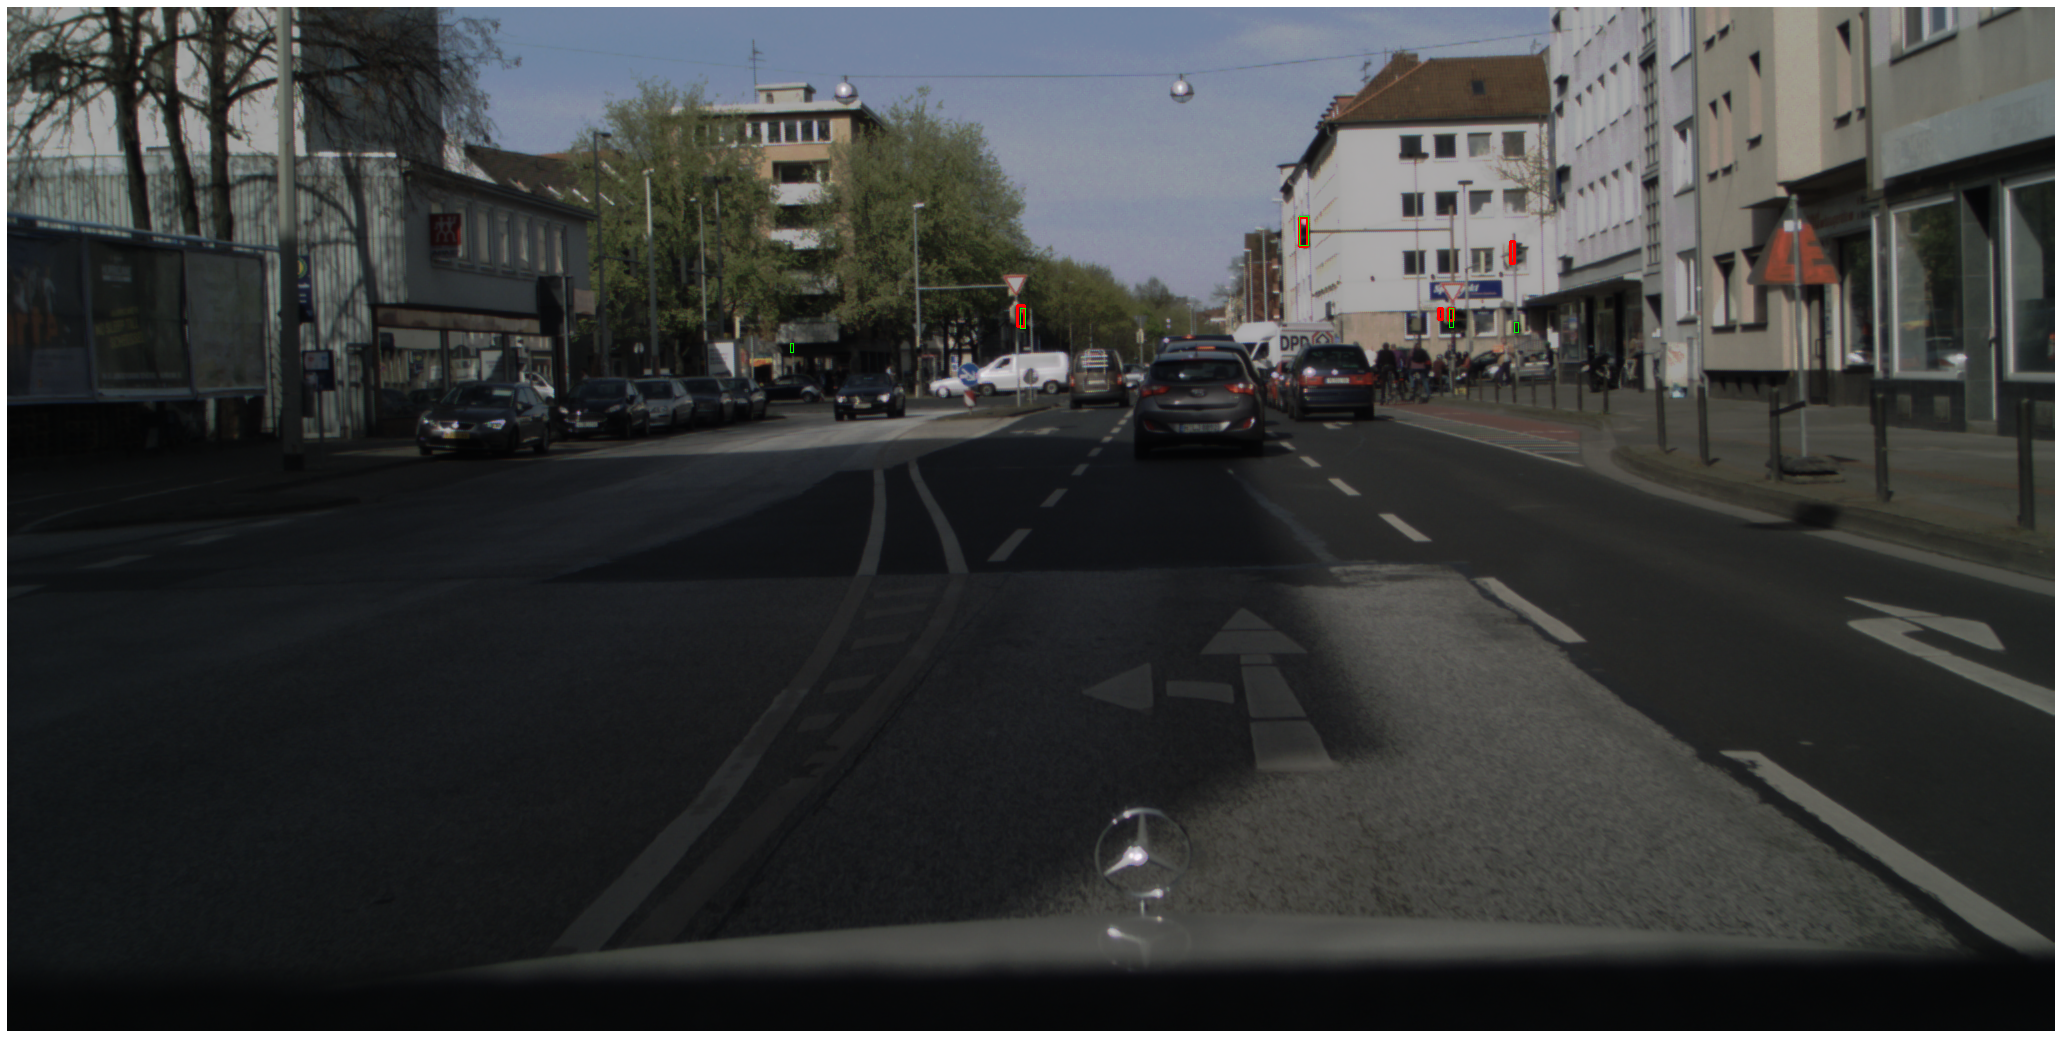

In [71]:
im_det2 = "/multiverse/datasets/shared/DTLD/Hannover/Hannover6/2015-04-20_16-55-27/DE_BBBR667_2015-04-20_16-55-34-911440_k0.tiff"
jsonpath = '/multiverse/datasets/shared/DTLD/detectron2/full_size_mini/DTLD_test_inference_results_feb.json'
display_image_in_actual_size(im_path=im_det2, json_path=jsonpath)

# Unrelated things

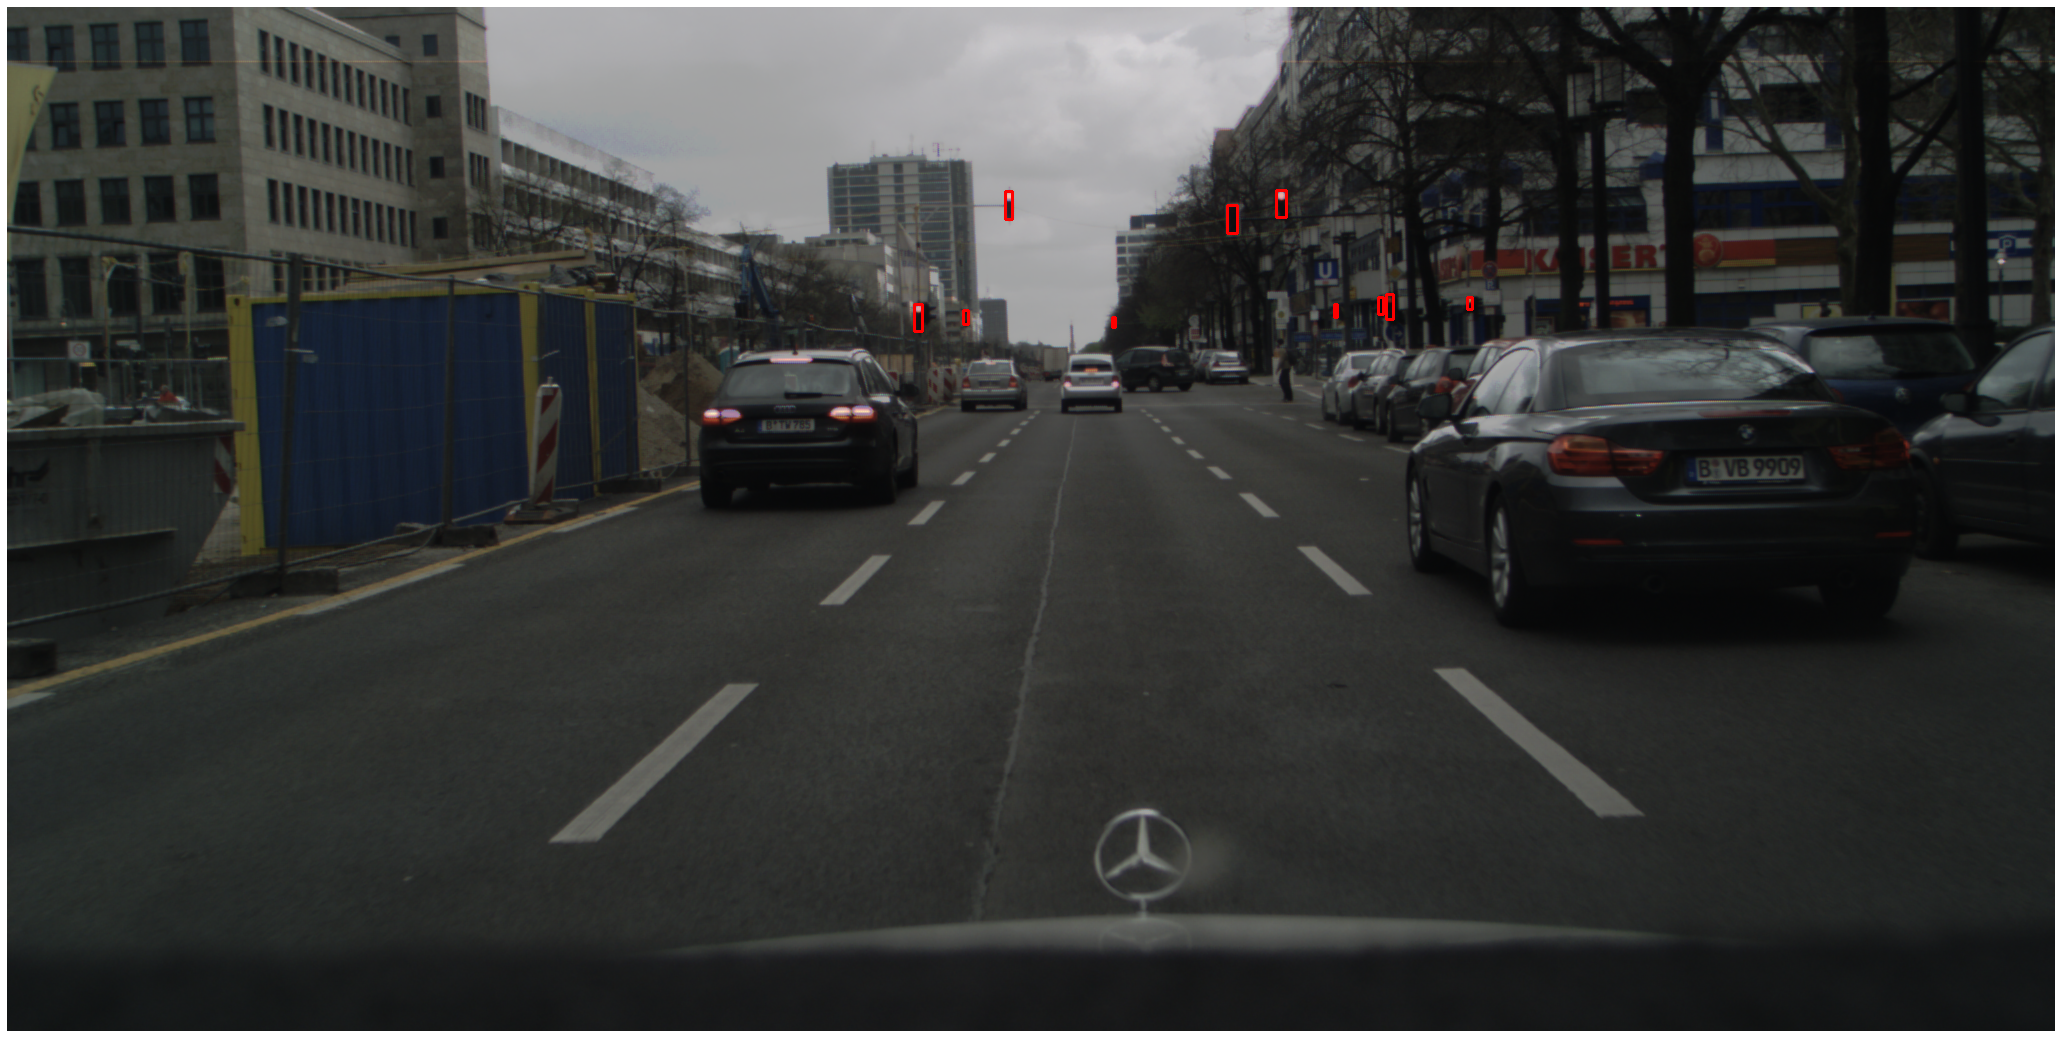

KeyboardInterrupt: Interrupted by user

In [51]:
import json

mini_path = '/multiverse/datasets/shared/DTLD/scripts/mini.json'
res = '/multiverse/datasets/shared/DTLD/detectron2/imsize_640_mini_p4only_4stride/DTLD_test_inference_results.json'
with open(res) as file:
    parsed = json.load(file)  
    
mini_dict = get_DTLD(parsed['images'])
    
paths = [image['file_name'] for image in mini_dict]
for path in paths:    
    display_image_in_actual_size([], path, None)
    _ = input('press smth')

In [17]:
import inspect
import logging
import numpy as np
from typing import Dict, List, Optional, Tuple
import torch
from torch import nn

# from detectron2.config import configurable
# from detectron2.layers import ShapeSpec, nonzero_tuple
from detectron2.structures import Boxes, ImageList, Instances, pairwise_iou
# from detectron2.utils.events import get_event_storage
# from detectron2.utils.registry import Registry

def forward2(
    self,
    images: ImageList,
    features: Dict[str, torch.Tensor],
    proposals: List[Instances],
    targets: Optional[List[Instances]] = None,
) -> Tuple[List[Instances], Dict[str, torch.Tensor]]:
    """
    See :class:`ROIHeads.forward`.
    """
#     print(inspect.stack())
#     print(targets[10].gt_classes)
    print(['FOUND AQ BURAYA BAK UZUN YAZIYORUM' if target.gt_classes.shape[0] == 0 else None for target in targets])
    del images
    if self.training:
        assert targets, "'targets' argument is required during training"
#          pdb.set_trace()
        proposals = self.label_and_sample_proposals(proposals, targets)
        
    del targets

    if self.training:
        losses = self._forward_box(features, proposals)
        # Usually the original proposals used by the box head are used by the mask, keypoint
        # heads. But when `self.train_on_pred_boxes is True`, proposals will contain boxes
        # predicted by the box head.
        losses.update(self._forward_mask(features, proposals))
        losses.update(self._forward_keypoint(features, proposals))
        return proposals, losses
    else:
        pred_instances = self._forward_box(features, proposals)
        # During inference cascaded prediction is used: the mask and keypoints heads are only
        # applied to the top scoring box detections.
        pred_instances = self.forward_with_given_boxes(features, pred_instances)
        return pred_instances, {}
    
# import detectron2.modeling.roi_heads.roi_heads as rh
# rh.StandardROIHeads.forward = forward2

from  detectron2.modeling.sampling import subsample_labels

def _sample_proposals2(
    self, matched_idxs: torch.Tensor, matched_labels: torch.Tensor, gt_classes: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Based on the matching between N proposals and M groundtruth,
    sample the proposals and set their classification labels.
    Args:
        matched_idxs (Tensor): a vector of length N, each is the best-matched
            gt index in [0, M) for each proposal.
        matched_labels (Tensor): a vector of length N, the matcher's label
            (one of cfg.MODEL.ROI_HEADS.IOU_LABELS) for each proposal.
        gt_classes (Tensor): a vector of length M.
    Returns:
        Tensor: a vector of indices of sampled proposals. Each is in [0, N).
        Tensor: a vector of the same length, the classification label for
            each sampled proposal. Each sample is labeled as either a category in
            [0, num_classes) or the background (num_classes).
    """
#     print(gt_classes)
#     print(['aq' if gt_classes.shape[0] == 0  else 0])
    has_gt = gt_classes.numel() > 0
    # Get the corresponding GT for each proposal
    if has_gt:
        gt_classes = gt_classes[matched_idxs]
        # Label unmatched proposals (0 label from matcher) as background (label=num_classes)
        gt_classes[matched_labels == 0] = self.num_classes
        # Label ignore proposals (-1 label)
        gt_classes[matched_labels == -1] = -1
    else:
        gt_classes = torch.zeros_like(matched_idxs) + self.num_classes

    sampled_fg_idxs, sampled_bg_idxs = subsample_labels(
        gt_classes, self.batch_size_per_image, self.positive_fraction, self.num_classes
    )

    sampled_idxs = torch.cat([sampled_fg_idxs, sampled_bg_idxs], dim=0)
    return sampled_idxs, gt_classes[sampled_idxs]

# rh.ROIHeads._sample_proposals = _sample_proposals2



def forward3(self, batched_inputs: List[Dict[str, torch.Tensor]]):
    """
    Args:
        batched_inputs: a list, batched outputs of :class:`DatasetMapper` .
            Each item in the list contains the inputs for one image.
            For now, each item in the list is a dict that contains:
            * image: Tensor, image in (C, H, W) format.
            * instances (optional): groundtruth :class:`Instances`
            * proposals (optional): :class:`Instances`, precomputed proposals.
            Other information that's included in the original dicts, such as:
            * "height", "width" (int): the output resolution of the model, used in inference.
              See :meth:`postprocess` for details.
    Returns:
        list[dict]:
            Each dict is the output for one input image.
            The dict contains one key "instances" whose value is a :class:`Instances`.
            The :class:`Instances` object has the following keys:
            "pred_boxes", "pred_classes", "scores", "pred_masks", "pred_keypoints"
    """
    if not self.training:
        return self.inference(batched_inputs)
    
    print(batched_inputs)

    images = self.preprocess_image(batched_inputs)
    if "instances" in batched_inputs[0]:
        gt_instances = [x["instances"].to(self.device) for x in batched_inputs]
    else:
        gt_instances = None
        
#     print([inst if inst.gt_classes.shape[0] == 0 else None for inst in gt_instances])

    features = self.backbone(images.tensor)

    if self.proposal_generator is not None:
        proposals, proposal_losses = self.proposal_generator(images, features, gt_instances)
    else:
        assert "proposals" in batched_inputs[0]
        proposals = [x["proposals"].to(self.device) for x in batched_inputs]
        proposal_losses = {}

    _, detector_losses = self.roi_heads(images, features, proposals, gt_instances)
    if self.vis_period > 0:
        storage = get_event_storage()
        if storage.iter % self.vis_period == 0:
            self.visualize_training(batched_inputs, proposals)

    losses = {}
    losses.update(detector_losses)
    losses.update(proposal_losses)
    return losses

# detectron2.modeling.meta_arch.rcnn.GeneralizedRCNN.forward = forward3



def run_step2(self):
    """
    Implement the standard training logic described above.
    """
    assert self.model.training, "[SimpleTrainer] model was changed to eval mode!"
    start = time.perf_counter()
    """
    If you want to do something with the data, you can wrap the dataloader.
    """
    data = next(self._data_loader_iter)
    print(data)
    data_time = time.perf_counter() - start

    """
    If you want to do something with the losses, you can wrap the model.
    """
    loss_dict = self.model(data)
    if isinstance(loss_dict, torch.Tensor):
        losses = loss_dict
        loss_dict = {"total_loss": loss_dict}
    else:
        losses = sum(loss_dict.values())

    """
    If you need to accumulate gradients or do something similar, you can
    wrap the optimizer with your custom `zero_grad()` method.
    """
    self.optimizer.zero_grad()
    losses.backward()

    self._write_metrics(loss_dict, data_time)

    """
    If you need gradient clipping/scaling or other processing, you can
    wrap the optimizer with your custom `step()` method. But it is
    suboptimal as explained in https://arxiv.org/abs/2006.15704 Sec 3.2.4
    """
    self.optimizer.step()

# detectron2.engine.train_loop.SimpleTrainer.run_step = run_step2


In [52]:
image_size = (640, 640)
bbox = [679, 229, 681, 262]
bbox = np.array([bbox[0]*640/2048, bbox[1]*640/1024, bbox[2]*640/2048, bbox[3]*640/1024], dtype=np.uint8)
bbox
np.minimum(bbox, list(image_size + image_size)[::-1])

array([212, 143, 212, 131])

# SPLIT THE MONKEY PATCHING

In [ ]:
import itertools
import logging
import numpy as np
import operator
import pickle
import torch
import torch.utils.data as torchdata
from tabulate import tabulate
from termcolor import colored

from detectron2.config import configurable
from detectron2.structures import BoxMode
from detectron2.utils.comm import get_world_size
from detectron2.utils.env import seed_all_rng
from detectron2.utils.file_io import PathManager
from detectron2.utils.logger import _log_api_usage, log_first_n

from detectron2.data.catalog import DatasetCatalog, MetadataCatalog
from detectron2.data.common import AspectRatioGroupedDataset, DatasetFromList, MapDataset, ToIterableDataset
# from detectron2.data.dataset_mapper import DatasetMapper
from detectron2.data.detection_utils import check_metadata_consistency
from detectron2.data.samplers import (
    InferenceSampler,
    RandomSubsetTrainingSampler,
    RepeatFactorTrainingSampler,
    TrainingSampler,
)
from detectron2.data.build import _train_loader_from_config

###############################################################################

@configurable(from_config=_train_loader_from_config)
def build_detection_train_loader2(
    dataset,
    *,
    mapper,
    sampler=None,
    total_batch_size,
    aspect_ratio_grouping=True,
    num_workers=0,
    collate_fn=None,
):
    """
    Build a dataloader for object detection with some default features.
    This interface is experimental.
    Args:
        dataset (list or torch.utils.data.Dataset): a list of dataset dicts,
            or a pytorch dataset (either map-style or iterable). It can be obtained
            by using :func:`DatasetCatalog.get` or :func:`get_detection_dataset_dicts`.
        mapper (callable): a callable which takes a sample (dict) from dataset and
            returns the format to be consumed by the model.
            When using cfg, the default choice is ``DatasetMapper(cfg, is_train=True)``.
        sampler (torch.utils.data.sampler.Sampler or None): a sampler that produces
            indices to be applied on ``dataset``.
            If ``dataset`` is map-style, the default sampler is a :class:`TrainingSampler`,
            which coordinates an infinite random shuffle sequence across all workers.
            Sampler must be None if ``dataset`` is iterable.
        total_batch_size (int): total batch size across all workers. Batching
            simply puts data into a list.
        aspect_ratio_grouping (bool): whether to group images with similar
            aspect ratio for efficiency. When enabled, it requires each
            element in dataset be a dict with keys "width" and "height".
        num_workers (int): number of parallel data loading workers
        collate_fn: same as the argument of `torch.utils.data.DataLoader`.
            Defaults to do no collation and return a list of data.
            No collation is OK for small batch size and simple data structures.
            If your batch size is large and each sample contains too many small tensors,
            it's more efficient to collate them in data loader.
    Returns:
        torch.utils.data.DataLoader:
            a dataloader. Each output from it is a ``list[mapped_element]`` of length
            ``total_batch_size / num_workers``, where ``mapped_element`` is produced
            by the ``mapper``.
    """
    
    pdb.set_trace()
    if isinstance(dataset, list):
        dataset = DatasetFromList(dataset, copy=False)
    if mapper is not None:
        dataset2 = MapDataset(dataset, mapper)

    if isinstance(dataset, torchdata.IterableDataset):
        assert sampler is None, "sampler must be None if dataset is IterableDataset"
    else:
        if sampler is None:
            sampler = TrainingSampler(len(dataset))
        assert isinstance(sampler, torchdata.Sampler), f"Expect a Sampler but got {type(sampler)}"
    return build_batch_data_loader(
        dataset,
        sampler,
        total_batch_size,
        aspect_ratio_grouping=aspect_ratio_grouping,
        num_workers=num_workers,
        collate_fn=collate_fn,
    )
import detectron2.data.build as bu
# bu.build_detection_train_loader = build_detection_train_loader2
# detectron2.data.build.build_detection_train_loader = build_detection_train_loader2


# def build_batch_data_loader2(
#     dataset,
#     sampler,
#     total_batch_size,
#     *,
#     aspect_ratio_grouping=False,
#     num_workers=0,
#     collate_fn=None,
# ):
#     """
#     Build a batched dataloader. The main differences from `torch.utils.data.DataLoader` are:
#     1. support aspect ratio grouping options
#     2. use no "batch collation", because this is common for detection training
#     Args:
#         dataset (torch.utils.data.Dataset): a pytorch map-style or iterable dataset.
#         sampler (torch.utils.data.sampler.Sampler or None): a sampler that produces indices.
#             Must be provided iff. ``dataset`` is a map-style dataset.
#         total_batch_size, aspect_ratio_grouping, num_workers, collate_fn: see
#             :func:`build_detection_train_loader`.
#     Returns:
#         iterable[list]. Length of each list is the batch size of the current
#             GPU. Each element in the list comes from the dataset.
#     """
#     world_size = get_world_size()
#     assert (
#         total_batch_size > 0 and total_batch_size % world_size == 0
#     ), "Total batch size ({}) must be divisible by the number of gpus ({}).".format(
#         total_batch_size, world_size
#     )
#     batch_size = total_batch_size // world_size
#     aspect_ratio_grouping=False
#     pdb.set_trace()
    

#     if isinstance(dataset, torchdata.IterableDataset):
#         assert sampler is None, "sampler must be None if dataset is IterableDataset"
#     else:
#         dataset = ToIterableDataset(dataset, sampler)
# #     print(list(dataset))

#     if aspect_ratio_grouping:
#         data_loader = torchdata.DataLoader(
#             dataset,
#             num_workers=num_workers,
#             collate_fn=operator.itemgetter(0),  # don't batch, but yield individual elements
#             worker_init_fn=worker_init_reset_seed,
#         )  # yield individual mapped dict
#         data_loader = AspectRatioGroupedDataset(data_loader, batch_size)
#         if collate_fn is None:
#             return data_loader
#         return MapDataset(data_loader, collate_fn)
#     else:
#         amciksin = torchdata.DataLoader(
#             dataset,
#             batch_size=batch_size,
#             drop_last=True,
#             num_workers=num_workers,
#             collate_fn=trivial_batch_collator if collate_fn is None else collate_fn,
#             worker_init_fn=worker_init_reset_seed,
#         )
    
#         pdb.set_trace()
#         return torchdata.DataLoader(
#             dataset,
#             batch_size=batch_size,
#             drop_last=True,
#             num_workers=num_workers,
#             collate_fn=trivial_batch_collator if collate_fn is None else collate_fn,
#             worker_init_fn=worker_init_reset_seed,
#         )
    

# detectron2.data.build.build_batch_data_loader = build_batch_data_loader2

# def trivial_batch_collator(batch):
#     """
#     A batch collator that does nothing.
#     """
#     return batch

# def worker_init_reset_seed(worker_id):
#     initial_seed = torch.initial_seed() % 2 ** 31
#     seed_all_rng(initial_seed + worker_id)  
    


In [ ]:
%matplotlib inline
import json
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200  

metrics_path = '/multiverse/datasets/shared/DTLD/detectron2/imsize_640_mini_bestcheck/metrics.json'
lr = []
iters = []
prev_iter = 0

with open(metrics_path) as f:
    metrics = json.load(f)
for idx, data in enumerate(metrics['res']):
    if "lr" in data:
        lr.append(data["lr"])
        iters.append(data["iteration"])
        prev_iter = data["iteration"]

plt.plot(iters, lr)

   

# ANCHOR-GT matching

In [ ]:

                # thres_list = (output.T[0][1:] - output.T[0][:-1] < 1.5) \
                #              * (output.T[1][1:] - output.T[1][:-1] < 1.5)
                # thres_list = np.concatenate((np.array([False]), thres_list))
                # group_idx = thres_list.nonzero()[0]

                # same_group = group_idx - np.arange(group_idx[0], group_idx[0] + len(group_idx))
                # uniq = np.unique(same_group)
                # if len(uniq) != len(same_group):  # there are more than 2 predictions that should be grouped 
                    
                labels = output

                # if len(group_idx) == 1:
                #     grouped_list = [np.concatenate(
                #                                     (labels[group_idx], 
                #                                      labels[group_idx-1])
                #                                   ).tolist()]

                # else:
                #     grouped_list = [list(label) for label in 
                #                     zip(labels[group_idx].tolist(), 
                #                         labels[group_idx-1].tolist())]

                # in_group = labels[group_idx].tolist() + labels[group_idx-1].tolist()
                # not_grouped = [[label] for label in labels.tolist() 
                #                 if label not in in_group]
                # grouped_list.extend(not_grouped)          
                # chunk = [list(j) for i, j in groupby(output.tolist(), key=lambda x: (x[0], )]
                
                
                

                        # if np.count_nonzero(ind) == 1:
                            
                                                               
                        #     aspect = att[classes[ind].item()]  
                        #     direction = att[classes[~ind].item()]
                        # else:
                        #     scores = np.array([int(anno[4]) for anno in label_group])
                        #     idx = np.argsort(scores)
                        #     cls = classes[idx][-1]  # take highest score class
                        #     if np.count_nonzero(ind) == 2:
                        #         aspect = att[cls]       
                        #         direction = att[3] 
                        #     else:
                        #         aspect = att[2]   # put most common one for now
                        #         direction = att[cls]  


In [77]:
# readimg  -> img
# xyxy -> x 
# label ->  label = '%s%.2f' % (names[int(cls)],conf.item())
import cv2
import random
import os

def plot_one_box(x, img, color=None, label=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (x[0], x[1]), (x[2], x[3])
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 6, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 6, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

def yolo_style_detect(json_path):
    with open(json_path) as file:
        parsed = json.load(file)
    images = parsed['images']
    for image in images:
        im_path = image["image_path"]
        path_split = im_path.split('/')
        path_split[0] = '/multiverse/datasets/shared/DTLD'
        im_path = '/'.join(path_split)
        img = read_image2(im_path)
        for label in image["labels"]:
            x = label['x']
            y = label['y']
            w = label['w']
            h = label['h'] 
            x2 = x + w
            y2 = y + h
            anno = [x, y, x2, y2]
            label_txt = '%s %s' % (label["attributes"]["aspects"], label["attributes"]["direction"])
            plot_one_box(anno, img, color=None, label=label_txt, line_thickness=2)
        save_dir = '/multiverse/datasets/shared/DTLD/detectron2/yolo_style'
        im_name = im_path.split('/')[-1]    
        save_path = os.path.join(save_dir, im_name) 
        cv2.imwrite(save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        

In [79]:
json_path = '/multiverse/datasets/shared/DTLD/detectron2/full_size_mini/mini_3.json'
yolo_style_detect(json_path)

STOP
STOP
STOP


In [33]:
import numpy as np
yarrak = np.array([])
ycs = np.array([[1.3,5], 'anan'])
amcik = np.array([[1.3,31], 'baban'])
yarrak = np.concatenate([yarrak, ycs])
yarrak = np.concatenate([yarrak, amcik])

# np.append(yarrak, [yarrak, amcik])

In [34]:
yarrak.reshape(())

array([list([1.3, 5]), 'anan', list([1.3, 31]), 'baban'], dtype=object)

In [12]:
ycs[1]

'anan'